# VO2max Prediction Using Treadmill Maximal Exercise Tests and Machine Learning Techniques

In [1]:
# import packages
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import signal
from collections import Counter
from sklearn.utils import indexable
from sklearn.utils import resample
from sklearn.utils.validation import _num_samples
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from itertools import chain
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, MultiTaskLassoCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from math import ceil, floor

In [2]:
# load subject dataset
subject_data = pd.read_csv('physionet.org/files/treadmill-exercise-cardioresp/1.0.1/subject-info.csv')

# basic information
display(subject_data.head())
print("Initial Dataset Info:")
print(subject_data.info())
print(subject_data.describe())

,Age,Weight,Height,Humidity,Temperature,Sex,ID,ID_test
0,10.8,48.8,163.0,39.0,20.7,1,543,543_1
1,11.8,41.0,150.0,41.0,22.3,1,11,11_1
2,12.2,46.0,160.0,37.0,21.5,0,829,829_1
3,13.2,71.0,190.0,49.0,23.8,1,284,284_1
4,13.7,53.8,169.7,40.0,25.3,0,341,341_1


Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          992 non-null    float64
 1   Weight       992 non-null    float64
 2   Height       992 non-null    float64
 3   Humidity     962 non-null    float64
 4   Temperature  962 non-null    float64
 5   Sex          992 non-null    int64  
 6   ID           992 non-null    int64  
 7   ID_test      992 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 62.1+ KB
None
              Age      Weight      Height    Humidity  Temperature  \
count  992.000000  992.000000  992.000000  962.000000   962.000000   
mean    28.979133   73.383367  174.913508   48.211435    22.818565   
std     10.076653   12.005361    7.950027    8.560991     2.784066   
min     10.800000   41.000000  150.000000   23.700000    15.000000   
25%     21.100000   66.000000  170.0

In [3]:
# load measurement dataset
measurement_data = pd.read_csv('physionet.org/files/treadmill-exercise-cardioresp/1.0.1/test_measure.csv')

# basic information
measurement_data

,time,Speed,HR,VO2,VCO2,RR,VE,ID_test,ID
0,0,5.0,63.0,478.0,360.0,27,13.3,2_1,2
1,2,5.0,75.0,401.0,295.0,23,10.3,2_1,2
2,4,5.0,82.0,449.0,319.0,29,12.2,2_1,2
3,7,5.0,87.0,461.0,340.0,28,12.8,2_1,2
4,9,5.0,92.0,574.0,417.0,28,14.6,2_1,2
...,...,...,...,...,...,...,...,...,...
575082,926,5.0,148.0,1350.0,1699.0,35,65.7,857_1,857
575083,927,5.0,147.0,1275.0,1605.0,32,60.1,857_1,857
575084,929,5.0,147.0,1259.0,1566.0,29,57.0,857_1,857
575085,931,5.0,147.0,1278.0,1587.0,31,58.5,857_1,857


In [4]:
# merge both datasets on ID
#merged_data = pd.merge(measurement_data, subject_data, on='ID', how='inner')
merged_data = measurement_data
merged_data

,time,Speed,HR,VO2,VCO2,RR,VE,ID_test,ID
0,0,5.0,63.0,478.0,360.0,27,13.3,2_1,2
1,2,5.0,75.0,401.0,295.0,23,10.3,2_1,2
2,4,5.0,82.0,449.0,319.0,29,12.2,2_1,2
3,7,5.0,87.0,461.0,340.0,28,12.8,2_1,2
4,9,5.0,92.0,574.0,417.0,28,14.6,2_1,2
...,...,...,...,...,...,...,...,...,...
575082,926,5.0,148.0,1350.0,1699.0,35,65.7,857_1,857
575083,927,5.0,147.0,1275.0,1605.0,32,60.1,857_1,857
575084,929,5.0,147.0,1259.0,1566.0,29,57.0,857_1,857
575085,931,5.0,147.0,1278.0,1587.0,31,58.5,857_1,857


## Feature Selection

The feature selection process is based on the Paper: ... .

### Data Cleaning and Pre-processing

In [5]:
# check if there are missing values
print(merged_data.isnull().sum())

time          0
Speed         0
HR          981
VO2        4871
VCO2       4871
RR            0
VE            0
ID_test       0
ID            0
dtype: int64


In [6]:
# remove rows with missing target variable (HR, VO2)
merged_data_cleaned = merged_data.dropna(subset=['HR', 'VO2'])

# Check how many rows are removed
print(f'Rows removed due to missing HR or VO2: {len(merged_data) - len(merged_data_cleaned)}')

Rows removed due to missing HR or VO2: 5840


In [7]:
# if all data from one specific test_ID has to be removed where missing values of HR or VO2 are present
difference = pd.merge(merged_data, merged_data_cleaned, how='outer', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)
exclude_ids = difference['ID_test'].unique()

merged_data_cleaned = merged_data_cleaned[~merged_data_cleaned['ID_test'].isin(exclude_ids)]

In [8]:
print("Exercise Data RR Intervals:")
merged_data_cleaned['RR']

Exercise Data RR Intervals:


602       30
603       29
604       29
605       32
606       34
          ..
575082    35
575083    32
575084    29
575085    31
575086    31
Name: RR, Length: 381609, dtype: int64

In [9]:
# remove RR intervals exclusive to the range 300-2000 ms
# those are considered as outliers
# Entferne RR-Werte, die außerhalb des Bereichs von 5-50 Atemzügen pro Minute liegen (Ausreißer)
merged_data_cleaned['RR'] = np.where((merged_data_cleaned['RR'] < 5) | (merged_data_cleaned['RR'] > 50), np.nan, merged_data_cleaned['RR'])

# linear interpolation to fill missing values
merged_data_cleaned['RR'] = merged_data_cleaned['RR'].interpolate(method='linear')

# Check for NaN values after interpolation
merged_data_cleaned.isnull().sum()

time       0
Speed      0
HR         0
VO2        0
VCO2       0
RR         0
VE         0
ID_test    0
ID         0
dtype: int64

In [10]:
# remove data points where HR and VO2 are out of ohase
delta_hr = np.diff(merged_data_cleaned['HR'])
delta_vo2max = np.diff(merged_data_cleaned['VO2'])

merged_data_cleaned = merged_data_cleaned.iloc[:-1]  # Drop the last row
in_phase_mask = (delta_hr * delta_vo2max) > 0  # Create a mask for in-phase points
merged_data_cleaned = merged_data_cleaned[in_phase_mask]


In [11]:
#  remove where consecutive HR differs more by than 30 bpm_
merged_data_cleaned['HR_diff'] = merged_data_cleaned['HR'].diff().abs()
merged_data_cleaned = merged_data_cleaned[merged_data_cleaned['HR_diff'] <= 30]

# remove objects with less than 5 minutes of data
merged_data_cleaned['time'] = merged_data_cleaned['time'].astype(float)  # make it numeirc
merged_data_cleaned = merged_data_cleaned[merged_data_cleaned['time'] >= 300]

# check dataset
print(f'Dataset size after cleaning: {merged_data_cleaned.shape}')

Dataset size after cleaning: (66300, 10)


In [12]:
# split data into exercise and recovery phases
exercise_data = merged_data_cleaned[merged_data_cleaned['Speed'] >= 5]  # Exercise phase
recovery_data = merged_data_cleaned[merged_data_cleaned['Speed'] < 5]  # Recovery phase

# shapes of dataframes
print(f'Exercise data size: {exercise_data.shape}')
print(f'Recovery data size: {recovery_data.shape}')

Exercise data size: (58349, 10)
Recovery data size: (7951, 10)


## Feature Extraction

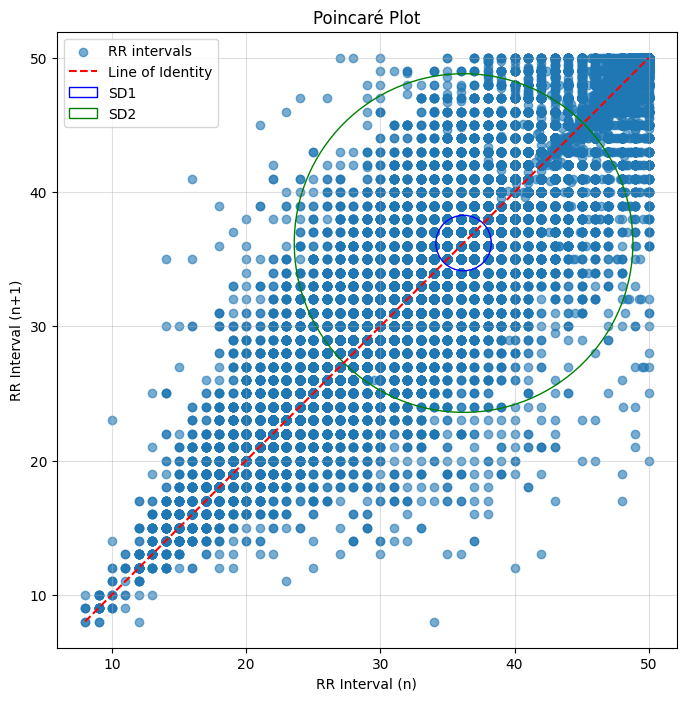

SD1: 2.06 ms
SD2: 12.62 ms


In [13]:
# Sample RR intervals (replace with your own data)
rr_intervals = merged_data_cleaned['RR'].values
# Calculate consecutive differences
rr_diff1 = rr_intervals[:-1]
rr_diff2 = rr_intervals[1:]

# Calculate mean of RR intervals
rr_mean = np.mean(rr_intervals)

# Calculate SD1 and SD2
sd1 = np.sqrt(0.5) * np.std(rr_diff2 - rr_diff1)
sd2 = np.sqrt(2 * np.std(rr_diff1)**2 - sd1**2)

# Line of identity
identity_line = np.linspace(min(rr_intervals), max(rr_intervals), 100)

# Create Poincaré plot
plt.figure(figsize=(8, 8))
plt.scatter(rr_diff1, rr_diff2, alpha=0.6, label="RR intervals")
plt.plot(identity_line, identity_line, color="red", linestyle="--", label="Line of Identity")
plt.xlim(min(rr_intervals), max(rr_intervals)+20)
plt.ylim(min(rr_intervals), max(rr_intervals)+20)
# SD1 and SD2 ellipse visualization
mean_rr = [np.mean(rr_diff1), np.mean(rr_diff2)]
ellipse_angle = 45
ellipse_sd1 = plt.Circle(mean_rr, sd1, color="blue", fill=False, label="SD1")
ellipse_sd2 = plt.Circle(mean_rr, sd2, color="green", fill=False, label="SD2")
plt.gca().add_patch(ellipse_sd1)
plt.gca().add_patch(ellipse_sd2)

# Formatting
plt.title("Poincaré Plot")
plt.xlabel("RR Interval (n)")
plt.ylabel("RR Interval (n+1)")
plt.legend()
plt.grid(alpha=0.4)
plt.axis("equal")
plt.show()

# Print SD1 and SD2
print(f"SD1: {sd1:.2f} ms")
print(f"SD2: {sd2:.2f} ms")


In [14]:
# auch mit chat GPT lol
from scipy.signal import welch
from scipy.stats import linregress, shapiro

def calculate_slopes(df, feature):
    if len(df) == 0:
        return np.nan
    else:
        slope = linregress(df['time'], df[feature]).slope
        return slope

# all HR Features

def compute_hr_features(segment: pd.DataFrame) -> dict:

    hr = segment['HR'].values
    time = segment['time'].values
    rr_intervals = segment['RR'].values 

    # Zeit-Domain-Features
    rmssd = np.sqrt(np.mean(np.diff(rr_intervals) ** 2))  # Berechnung von RMSSD
    pnn20 = np.mean(np.abs(np.diff(rr_intervals)) > 0.5) * 100  # Prozentsatz der Differenzen > 20 ms ~ 0.5 respiration/min
    pnn50 = np.mean(np.abs(np.diff(rr_intervals)) > 1.25) * 100  # Prozentsatz der Differenzen > 50 ms
    nni20 = np.sum(np.abs(np.diff(rr_intervals)) > 0.5)      # Anzahl der Differenzen > 20 ms
    nni50 = np.sum(np.abs(np.diff(rr_intervals)) > 1.25)      # Anzahl der Differenzen > 50 ms
    nni_range = np.max(rr_intervals) - np.min(rr_intervals)  # Bereich zwischen max. und min. RR-Intervall
    
    # Frequenz-Domain-Features
    
    # total_power = np.var(detrend(rr_intervals))  # Gesamtvarianz nach Detrend
    # vlf_power = total_power * 0.1  # Dummy-Verhältnis für VLF-Power (simuliert)
    # lf_power = total_power * 0.3  # Dummy-Verhältnis für LF-Power (simuliert)
    # hf_power = total_power * 0.6  # Dummy-Verhältnis für HF-Power (simuliert)
    
    fs = 4  # Annahme: Sampling-Frequenz von 4 Hz
    f, pxx = welch(rr_intervals, fs, nperseg=len(rr_intervals))
    vlf_power = np.trapz(pxx[(f >= 0.003) & (f < 0.04)], f[(f >= 0.003) & (f < 0.04)])
    lf_power = np.trapz(pxx[(f >= 0.04) & (f < 0.15)], f[(f >= 0.04) & (f < 0.15)])
    hf_power = np.trapz(pxx[(f >= 0.15) & (f < 0.4)], f[(f >= 0.15) & (f < 0.4)])
    lf_nu_power = lf_power / (vlf_power + lf_power + hf_power)

    # Nichtlineare Merkmale (Poincare Plot, DFA)
    sd1 = np.sqrt(0.5) * np.std(rr_diff2 - rr_diff1)
    sd2 = np.sqrt(2 * np.std(rr_diff1)**2 - sd1**2)
    
    # sd1 = np.std(rr_intervals[:len(rr_intervals)//2])  # Kurzfristige Variation (SD1)
    # sd2 = np.std(rr_intervals[len(rr_intervals)//2:])  # Langfristige Variation (SD2)

    # sd1 = np.std(hr[:len(hr)//2])
    # sd2 = np.std(hr[len(hr)//2:])
    
    # DFA (Detrended Fluctuation Analysis) als Platzhalter (echte Implementierung erfordert spezialisierte Bibliotheken)
    # Dummy-Wert für DFA a1 (z.B. von einer DFA-Analyse)
    #dfa_a1 = 0.75  # Beispielwert für DFA a1
    dfa_a1 = np.std(rr_intervals[:len(rr_intervals)//2]) / np.std(rr_intervals) # placeholder
    

    # Berechnung der Steigungen der Merkmale über die Zeit
    # Beispiel: Steigung des HRs über Zeit
    slope_nni = np.polyfit(time, hr, 1)[0]
    
    # # Steigungen für Poincare Plot-Merkmale
    # slope_sd1 = np.polyfit(time, [sd1] * len(time), 1)[0]
    # slope_sd2 = np.polyfit(time, [sd2] * len(time), 1)[0]

    # Zeitbasierte Merkmale (Beispiel)
    max_speed = segment['Speed'].max()
    max_hr = max(segment['HR'])
    min_hr = min(segment['HR'])
    slope_sp25 = calculate_slopes(segment[segment['Speed'] <= max_speed * 0.25], 'HR')
    slope_sp50 = calculate_slopes(segment[(segment['Speed'] <= max_speed * 0.5) & (segment['Speed'] > max_speed * 0.25)], 'HR')
    slope_sp75 = calculate_slopes(segment[(segment['Speed'] <= max_speed * 0.75) & (segment['Speed'] > max_speed * 0.5)], 'HR')
    slope_sp100 = calculate_slopes(segment[(segment['Speed'] > max_speed * 0.75)], 'HR')
    rt25 = segment.loc[segment['time'] <= segment['time'].max() * 0.25, 'HR'].corr(segment['time'])
    rt50 = segment.loc[(segment['time'] >= segment['time'].max() * 0.25) & (segment['time'] < segment['time'].max() * 0.5), 'HR'].corr(segment['time'])
    rt75 = segment.loc[(segment['time'] >= segment['time'].max() * 0.5) & (segment['time'] < segment['time'].max() * 0.75), 'HR'].corr(segment['time'])
    rsp75 = segment.loc[segment['Speed'] <= max_speed * 0.75, 'HR'].corr(segment['Speed'])
    rsp25 = segment.loc[segment['Speed'] <= max_speed * 0.25, 'HR'].corr(segment['Speed'])
    time_sp25 = segment[segment['Speed'] >= max_speed * 0.25]['time'].min()
    time_hr25 = segment[segment['HR'] >= max_hr * 0.25]['time'].min()
    time_hr50 = segment[segment['HR'] >= max_hr * 0.5]['time'].min()
    time_hr75 = segment[segment['HR'] >= max_hr * 0.75]['time'].min()
    duration_hr60 = len(segment[(segment['HR'] >= max_hr * 0.5) & (segment['HR'] < max_hr * 0.6)]) * (segment['time'].diff().mean())
    duration_hr70 = len(segment[(segment['HR'] >= max_hr * 0.6) & (segment['HR'] < max_hr * 0.7)]) * (segment['time'].diff().mean())
    duration_hr80 = len(segment[(segment['HR'] >= max_hr * 0.7) & (segment['HR'] < max_hr * 0.8)]) * (segment['time'].diff().mean())
    duration_hr90 = len(segment[(segment['HR'] >= max_hr * 0.8) & (segment['HR'] < max_hr * 0.9)]) * (segment['time'].diff().mean())
    duration_hr100 = len(segment[(segment['HR'] >= max_hr * 0.9) & (segment['HR'] <= max_hr)]) * (segment['time'].diff().mean())

    
    # Feature Dictionary
    Features = {'RMSSD': rmssd,
        'PNN20': pnn20,
        'PNN50': pnn50,
        'NNI20': nni20,
        'NNI50': nni50,
        'NNI_Range': nni_range,
        'VLF_Power': vlf_power,
        'LF_Power': lf_power,
        'HF_Power': hf_power,
        'LF_Nu_Power': lf_nu_power,
        'SD1': sd1,
        'SD2': sd2,
        'DFA_A1': dfa_a1,
        'Slope_NNI': slope_nni,
        'Slope_Speed25': slope_sp25,
        'Slope_Speed50': slope_sp50,
        'Slope_Speed75': slope_sp75,
        'Slope_Speed100': slope_sp100,
        'RT25': rt25,
        'RT50': rt50,
        'RT75': rt75,
        'RSP75': rsp75,
        'RSP25': rsp25,
        'Time_SP25': time_sp25,
        'Time_HR25': time_hr25,
        'Time_HR50': time_hr50,
        'Time_HR75': time_hr75,
        'DurationHR60': duration_hr60,
        'DurationHR70': duration_hr70,
        'DurationHR80': duration_hr80,
        'DurationHR90': duration_hr90,
        'DurationHR100': duration_hr100,
        'VO2max': segment['VO2'].max(),
    }
    
    return Features
    



In [15]:
def calculate_features_per_segment(df, test_column):
    """
    Berechnet Features für jedes Segment basierend auf der test_ID.
    
    Parameters:
    df (pd.DataFrame): Der DataFrame, der die Daten enthält.
    test_column (str): Der Name der Spalte, die die Test-IDs enthält.
    
    Returns:
    pd.DataFrame: Ein DataFrame mit den berechneten Features für jedes Segment.
    """
    # Leere Liste für die Features pro Segment
    all_features = []

    # Gehe durch jede Gruppe (Segment) basierend auf der test_ID
    for test_id, df_segment in df.groupby(test_column):
        # Berechne die Features für das aktuelle Segment
        features = compute_hr_features(df_segment)
        # Füge die Test-ID zu den Features hinzu
        features[test_column] = test_id
        # Hänge die Features für dieses Segment an die Liste an
        all_features.append(features)

    # Erstelle einen DataFrame aus der Liste der Features
    df_features = pd.DataFrame(all_features)
    return df_features

In [16]:
# just for testing the feature calculat
# for test_id, df_segment in merged_data_cleaned.groupby('ID_test'):
#     #print(test_id)
#     if test_id == '3_1':
#         test_segment = merged_data_cleaned[merged_data_cleaned['ID_test'] == test_id]
#         break
# compute_hr_features(test_segment)

In [17]:
additional_features_exercise = calculate_features_per_segment(exercise_data, 'ID_test')#ID_test_y')
additional_features_recovery = calculate_features_per_segment(recovery_data, 'ID_test')#ID_test_y')
#new_features['ID_test'] = new_features['ID_test_y']
merged_data_exercise = pd.merge(subject_data, additional_features_exercise, on='ID_test', how='inner')
merged_data_recovery = pd.merge(subject_data, additional_features_recovery, on='ID_test', how='inner')

/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multip

In [18]:
# normalize features
def normalize_features(dataframe):
    # Prüfen, welche Spalten numerisch sind (außer Zielvariablen oder IDs)
    numerical_features = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # StandardScaler für Normalisierung (mean=0, std=1)
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(dataframe[numerical_features])

    # In DataFrame umwandeln für Klarheit
    normalized_df = pd.DataFrame(normalized_data, columns=numerical_features)

    # Originale DataFrame kopieren und normalisierte Werte einfügen
    normalized_features = dataframe.copy()
    normalized_features[numerical_features] = normalized_df

    return normalized_features

normalized_features_exercise = normalize_features(merged_data_exercise)
normalized_features_recovery = normalize_features(merged_data_recovery)



/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/sklearn/u

In [19]:
def shapiro_wilk_test(dataframe):
    # Prüfen, welche Spalten numerisch sind (außer Zielvariablen oder IDs)
    numerical_features = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Shapiro-Wilk-Test für jede numerische Spalte
    shapiro_results = {}
    for column in numerical_features:
        stat, p = shapiro(dataframe[column])
        shapiro_results[column] = {'Statistic': stat, 'p-value': p}

    # Ergebnisse in DataFrame umwandeln
    shapiro_results_df = pd.DataFrame(shapiro_results).T
    shapiro_results_df.columns = ['Shapiro Statistic', 'p-value']
    
    # Identifizieren von Spalten, die nicht normalverteilt sind
    non_normal_features = shapiro_results_df[shapiro_results_df['p-value'] <= 0.05]

    return shapiro_results_df, non_normal_features


# Ergebnisse anzeigen
print("Shapiro-Wilk-Test Ergebnisse Exercise Data:")
shapiro_results_exercise, non_normal_features_exercise = shapiro_wilk_test(normalized_features_exercise)
#print(shapiro_results_exercise)
print("Shapiro-Wilk-Test Ergebnisse Recovery Data:")
shapiro_results_recovery, non_normal_features_recovery = shapiro_wilk_test(normalized_features_recovery)
#print(shapiro_results_recovery)

print("\nExercise Features, die NICHT normalverteilt sind:")
print(non_normal_features_exercise)
print("\nRecovery Features, die NICHT normalverteilt sind:")
print(non_normal_features_recovery)


Shapiro-Wilk-Test Ergebnisse Exercise Data:
Shapiro-Wilk-Test Ergebnisse Recovery Data:

Exercise Features, die NICHT normalverteilt sind:
                Shapiro Statistic       p-value
Age                      0.944843  6.085348e-15
Weight                   0.979253  4.776733e-08
Sex                      0.424351  2.271237e-41
ID                       0.963821  1.130394e-11
RMSSD                    0.961890  4.724737e-12
PNN20                    0.964520  1.561634e-11
PNN50                    0.994788  2.422459e-02
NNI50                    0.990518  3.020509e-04
NNI_Range                0.989046  7.817591e-05
LF_Power                 0.810771  4.373843e-27
HF_Power                 0.740825  8.370208e-31
DFA_A1                   0.957902  8.520009e-13
Slope_NNI                0.926532  2.018581e-17
Slope_Speed100           0.897118  1.338139e-20
RT75                     0.577465  4.404959e-37
Time_SP25                0.376181  1.591927e-42
Time_HR25                0.376181  1.591927e-

/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


A lot features are not normally distributed -> Feature Selection Methods that do not assume the data to be normally distributed (Mutual Information, Spearson Coefficient)

### Feature Correlation

In [20]:
normalized_features_exercise.columns

Index(['Age', 'Weight', 'Height', 'Humidity', 'Temperature', 'Sex', 'ID',
       'ID_test', 'RMSSD', 'PNN20', 'PNN50', 'NNI20', 'NNI50', 'NNI_Range',
       'VLF_Power', 'LF_Power', 'HF_Power', 'LF_Nu_Power', 'SD1', 'SD2',
       'DFA_A1', 'Slope_NNI', 'Slope_Speed25', 'Slope_Speed50',
       'Slope_Speed75', 'Slope_Speed100', 'RT25', 'RT50', 'RT75', 'RSP75',
       'RSP25', 'Time_SP25', 'Time_HR25', 'Time_HR50', 'Time_HR75',
       'DurationHR60', 'DurationHR70', 'DurationHR80', 'DurationHR90',
       'DurationHR100', 'VO2max'],
      dtype='object')

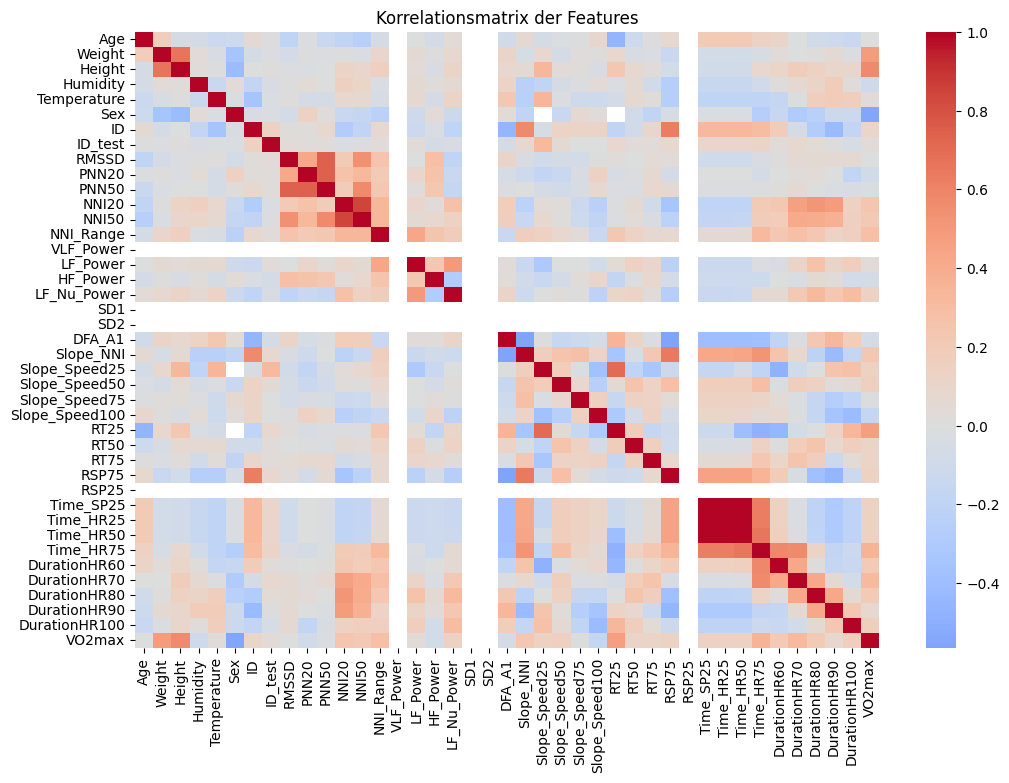


Stark korrelierte Feature-Paare:
      RMSSD     PNN20     PNN50               NNI20     NNI50 Slope_Speed25  \
      PNN50     PNN50     RMSSD     PNN20     NNI50     NNI20          RT25   
0  0.738346  0.739347  0.738346  0.739347  0.844753  0.844753      0.705314   

           RT25 Time_SP25           Time_HR25           Time_HR50            
  Slope_Speed25 Time_HR25 Time_HR50 Time_SP25 Time_HR50 Time_SP25 Time_HR25  
0      0.705314       1.0  0.994603       1.0  0.994603  0.994603  0.994603  


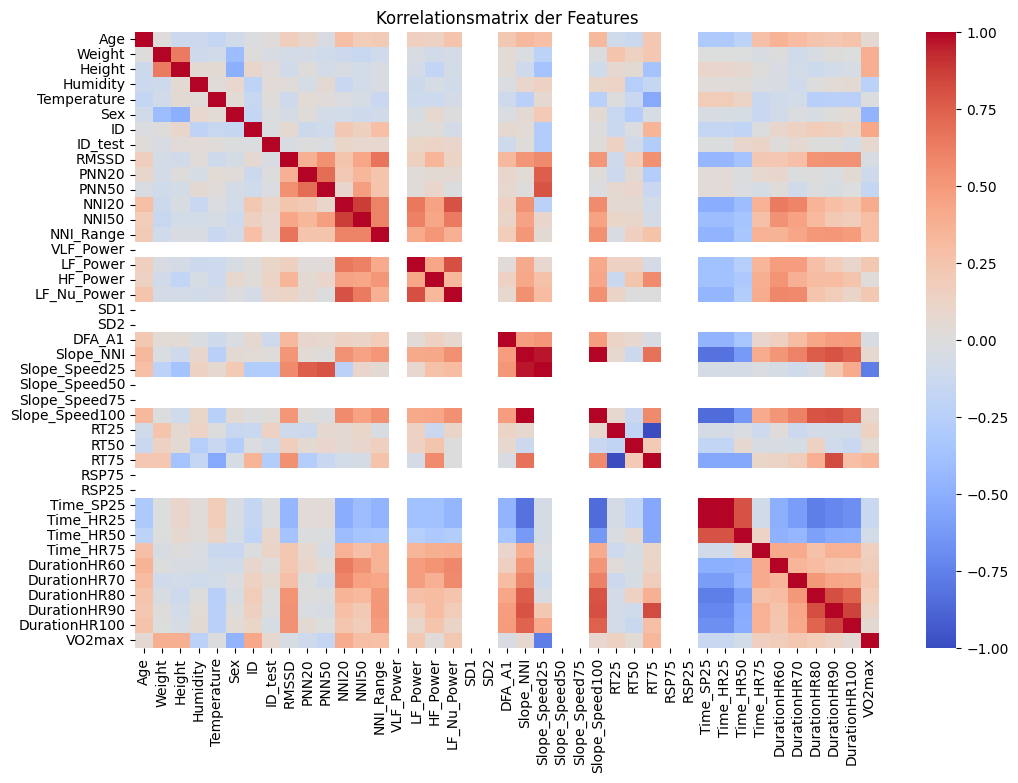


Stark korrelierte Feature-Paare:
          PNN20         PNN50     NNI20                 NNI50    LF_Power  \
  Slope_Speed25 Slope_Speed25     NNI50 LF_Nu_Power     NNI20 LF_Nu_Power   
0      0.756541      0.792772  0.869707    0.803358  0.869707     0.80598   

  LF_Nu_Power              Slope_NNI                 ... DurationHR90  \
        NNI20 LF_Power Slope_Speed25 Slope_Speed100  ...         RT75   
0    0.803358  0.80598      0.963967       0.999092  ...     0.823447   

                                                 DurationHR100                 \
  Time_SP25 Time_HR25 DurationHR80 DurationHR100     Slope_NNI Slope_Speed100   
0 -0.722457 -0.722457     0.819655      0.851614      0.742091       0.745605   

                                   VO2max  
  DurationHR80 DurationHR90 Slope_Speed25  
0     0.729549     0.851614     -0.768536  

[1 rows x 60 columns]


In [20]:
def correlated_features(dataframe, threshold=0.7):
    # Berechne die Korrelationsmatrix
    correlation_matrix = dataframe.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
    plt.title('Korrelationsmatrix der Features')
    plt.show()
    # Finde stark korrelierte Feature-Paare
    highly_correlated_pairs = correlation_matrix.where((correlation_matrix.abs() > threshold) & (np.eye(correlation_matrix.shape[0]) == 0)).stack()
    highly_correlated_pairs = pd.DataFrame(highly_correlated_pairs).T
    
    if not highly_correlated_pairs.empty:
        print("\nStark korrelierte Feature-Paare:")
        print(highly_correlated_pairs)

    return highly_correlated_pairs

highly_correlated_pairs_exercise = correlated_features(normalized_features_exercise, threshold=0.7)
highly_correlated_pairs_recovery = correlated_features(normalized_features_recovery, threshold=0.7)

# 3. Korrelation mit dem Zielwert
#correlation_with_target = normalized_features.corr()[target_column].drop(target_column)

# Features mit starker Korrelation zum Zielwert
#strongly_correlated_features = correlation_with_target[correlation_with_target.abs() > 0.5]
#print("Features mit starker Korrelation zum Zielwert:")
#print(strongly_correlated_features)

# 5. Mutual Information für nicht-lineare Zusammenhänge
#mi_scores = mutual_info_regression(features, target)
#mi_scores_df = pd.Series(mi_scores, index=features.columns).sort_values(ascending=False)
#print("\nMutual Information Scores:")
#print(mi_scores_df)

# 6. Scatterplots für interessante Features
#top_features = mi_scores_df.head(5).index  # Die 5 wichtigsten Features
#for feature in top_features:
 #   plt.figure(figsize=(6, 4))
  #  sns.scatterplot(x=features[feature], y=target)
   # plt.title(f"Zusammenhang zwischen {feature} und Zielwert")
    #plt.xlabel(feature)
    #plt.ylabel(target_column)
    #plt.show()


In [21]:
# remove highly correlated features
from collections import Counter
def remove_correlated_features(dataframe, highly_correlated_pairs):
    # Flatten pairs to count occurrences of each feature
    flat_features = [item for pair in highly_correlated_pairs for item in pair]
    feature_counts = Counter(flat_features)

    # Initialize sets to keep track of features to keep and drop
    features_to_keep = set()
    features_to_drop = set()

    # Process each pair to decide which feature to drop
    for feature1, feature2 in highly_correlated_pairs:
        # If neither feature is already marked for keeping, drop the less frequent one
        if feature1 not in features_to_keep and feature2 not in features_to_keep:
            if feature_counts[feature1] >= feature_counts[feature2]:
                features_to_keep.add(feature1)
                features_to_drop.add(feature2)
            else:
                features_to_keep.add(feature2)
                features_to_drop.add(feature1)
        # If one is already kept, drop the other
        elif feature1 in features_to_keep:
            features_to_drop.add(feature2)
        elif feature2 in features_to_keep:
            features_to_drop.add(feature1)

    # Get the final list of features to keep
    final_features = set(flat_features) - features_to_drop
    print(f"Features to keep: {sorted(final_features)}")
    print(f"Features to drop: {sorted(features_to_drop)}")
    reduced_data = dataframe.drop(columns=features_to_drop)
    return reduced_data


reduced_exercise_data = remove_correlated_features(normalized_features_exercise, highly_correlated_pairs_exercise)
reduced_recovery_data = remove_correlated_features(normalized_features_recovery, highly_correlated_pairs_recovery)

Features to keep: ['NNI20', 'PNN50', 'Slope_Speed25', 'Time_SP25']
Features to drop: ['NNI50', 'PNN20', 'RMSSD', 'RT25', 'Time_HR25', 'Time_HR50']
Features to keep: ['Slope_Speed25']
Features to drop: ['DurationHR100', 'DurationHR80', 'DurationHR90', 'LF_Nu_Power', 'LF_Power', 'NNI20', 'NNI50', 'PNN20', 'PNN50', 'RT25', 'RT75', 'Slope_NNI', 'Slope_Speed100', 'Time_HR25', 'Time_HR50', 'Time_SP25', 'VO2max']


In [22]:

# remove features that are nan for more than 50% of the data
def remove_nan_features(dataframe, threshold=0.5):
    nan_counts = dataframe.isnull().mean()
    features_to_remove = nan_counts[nan_counts > threshold].index
    print(f"Features to remove with more than {threshold * 100}% NaN values: {features_to_remove}")
    reduced_data = dataframe.drop(columns=features_to_remove)
    return reduced_data
cleaned_reduced_exercise_data = remove_nan_features(reduced_exercise_data)

Features to remove with more than 50.0% NaN values: Index(['Slope_Speed25', 'RSP25'], dtype='object')


In [23]:
cleaned_reduced_exercise_data

,Age,Weight,Height,Humidity,Temperature,Sex,ID,ID_test,PNN50,NNI20,...,RT75,RSP75,Time_SP25,Time_HR75,DurationHR60,DurationHR70,DurationHR80,DurationHR90,DurationHR100,VO2max
0,-1.593575,-2.289094,-1.890610,-1.319559,-0.518200,-0.417957,1.793371,829_1,-2.434399,-2.657191,...,0.277352,1.522298,-0.319703,-1.100823,-0.538828,-1.332304,-2.342757,-1.331338,0.263542,-1.882888
1,-1.492280,-0.219610,1.838549,0.061002,0.313438,2.392591,-0.516814,284_1,-0.745043,0.097537,...,0.517986,-0.744550,-0.248265,-0.297911,-0.538828,0.356262,0.360544,-0.477227,-0.209356,0.333769
2,-1.441632,-1.643415,-0.684849,-0.974419,0.855811,-0.417957,-0.275199,341_1,0.761215,1.447894,...,0.501078,-1.183903,-0.319703,1.077372,-0.014832,1.647507,0.661164,0.441586,0.458240,-0.072596
3,-1.431503,-1.676527,-0.523252,-0.744326,0.530387,-0.417957,-0.275199,341_2,3.062842,-0.064506,...,0.372632,-0.215502,0.094636,-0.870284,-0.341649,-0.984314,-1.131643,0.511607,-0.351883,-1.262853
4,-1.411244,-2.289094,-1.890610,-0.974419,0.855811,-0.417957,-0.266721,343_1,-0.236257,0.367608,...,0.507848,-0.279491,-0.219690,0.028023,-0.538828,0.638218,1.257712,1.176799,-0.966498,-0.906300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,3.116643,-0.633507,-0.485960,-1.204513,-2.868482,-0.417957,1.907821,856_1,0.559076,0.907751,...,-0.492992,1.616112,-0.176828,1.053523,1.147382,-0.423004,-0.185041,1.132063,-2.138808,-0.379337
655,3.157161,-0.741120,-0.398946,-1.204513,0.530387,-0.417957,1.907821,856_2,3.203252,-0.496620,...,0.493235,1.730790,0.051773,0.822984,0.626201,1.580490,0.161787,-1.013357,-1.761108,-0.329524
656,3.217938,-0.699731,-0.398946,0.291095,-2.217634,-0.417957,1.907821,856_3,2.730621,-0.172534,...,0.342822,1.670685,-0.162540,1.005825,0.253067,2.394543,0.251362,-1.732084,-1.734343,-0.832893
657,3.380010,2.346550,1.217022,0.866329,-0.879782,-0.417957,-0.067494,390_1,-0.196615,-0.334577,...,0.535419,-1.127586,-0.162540,-0.441005,-0.538828,-0.499372,0.638934,-0.326421,-0.636205,0.079463


In [24]:
# Feature Selection using Mutual Information

from sklearn.feature_selection import mutual_info_regression

def mutual_information_FS(dataframe, target_column, threshold=0.0):
    """
    Calculates mutual information scores between features and the target variable, and performs feature selection.

    Parameters:
        dataframe (pd.DataFrame): The input dataframe containing features and the target column.
        target_column (str): The name of the target column in the dataframe.
        threshold (float): Minimum mutual information score for a feature to be selected. Default is 0.0.

    Returns:
        pd.DataFrame: A dataframe containing features and their corresponding mutual information scores, sorted in descending order.
        pd.DataFrame: A new dataframe containing only the selected features (and the target column).
    """
    # Separate features and target
    X = dataframe.drop(columns=[target_column])
    y = dataframe[target_column]
    
    # ignore nan values
    X = X.dropna(axis=1)

    # Calculate mutual information scores
    mi_scores = mutual_info_regression(X, y)

    # Create a DataFrame for feature scores
    feature_scores = pd.DataFrame({
        'Feature': X.columns,
        'Mutual_Information': mi_scores
    })

    # Sort features by mutual information scores in descending order
    feature_scores = feature_scores.sort_values(by='Mutual_Information', ascending=False).reset_index(drop=True)
    #print(feature_scores)

    # Select features based on threshold
    selected_features = feature_scores[feature_scores['Mutual_Information'] > threshold]['Feature']
    
    print(f"Selected Features (MI > {threshold}): {selected_features.to_list()}")
    # Create a new dataframe with selected features and target
    selected_dataframe = dataframe[selected_features.to_list() + [target_column]]

    return feature_scores, selected_dataframe

mi_scores, selected_reduced_exercise_data = mutual_information_FS(cleaned_reduced_exercise_data, 'VO2max')
selected_reduced_exercise_data

Selected Features (MI > 0.0): ['Sex', 'Height', 'Weight', 'Time_HR75', 'ID', 'DurationHR60', 'DurationHR100', 'Slope_NNI', 'DurationHR70', 'DurationHR80', 'HF_Power', 'NNI20', 'Slope_Speed100', 'DurationHR90', 'Age', 'NNI_Range', 'LF_Power', 'Time_SP25', 'DFA_A1', 'SD2', 'VLF_Power', 'SD1']


,Sex,Height,Weight,Time_HR75,ID,DurationHR60,DurationHR100,Slope_NNI,DurationHR70,DurationHR80,...,DurationHR90,Age,NNI_Range,LF_Power,Time_SP25,DFA_A1,SD2,VLF_Power,SD1,VO2max
0,-0.417957,-1.890610,-2.289094,-1.100823,1.793371,-0.538828,0.263542,0.953762,-1.332304,-2.342757,...,-1.331338,-1.593575,-2.524519,-0.944851,-0.319703,1.515581,-3.552714e-15,0.0,0.0,-1.882888
1,2.392591,1.838549,-0.219610,-0.297911,-0.516814,-0.538828,-0.209356,-0.368417,0.356262,0.360544,...,-0.477227,-1.492280,-0.720303,-0.206672,-0.248265,1.728003,-3.552714e-15,0.0,0.0,0.333769
2,-0.417957,-0.684849,-1.643415,1.077372,-0.275199,-0.014832,0.458240,0.160058,1.647507,0.661164,...,0.441586,-1.441632,-0.900724,-0.775772,-0.319703,0.227644,-3.552714e-15,0.0,0.0,-0.072596
3,-0.417957,-0.523252,-1.676527,-0.870284,-0.275199,-0.341649,-0.351883,-1.382211,-0.984314,-1.131643,...,0.511607,-1.431503,-1.261567,-0.691533,0.094636,0.838901,-3.552714e-15,0.0,0.0,-1.262853
4,-0.417957,-1.890610,-2.289094,0.028023,-0.266721,-0.538828,-0.966498,-0.592033,0.638218,1.257712,...,1.176799,-1.411244,-1.261567,-0.930014,-0.219690,1.295237,-3.552714e-15,0.0,0.0,-0.906300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,-0.417957,-0.485960,-0.633507,1.053523,1.907821,1.147382,-2.138808,0.872334,-0.423004,-0.185041,...,1.132063,3.116643,-0.539881,-0.784247,-0.176828,-0.163487,-3.552714e-15,0.0,0.0,-0.379337
655,-0.417957,-0.398946,-0.741120,0.822984,1.907821,0.626201,-1.761108,1.238259,1.580490,0.161787,...,-1.013357,3.157161,0.542649,-0.205632,0.051773,-0.966697,-3.552714e-15,0.0,0.0,-0.329524
656,-0.417957,-0.398946,-0.699731,1.005825,1.907821,0.253067,-1.734343,1.174441,2.394543,0.251362,...,-1.732084,3.217938,0.362227,-0.809401,-0.162540,-0.726168,-3.552714e-15,0.0,0.0,-0.832893
657,-0.417957,1.217022,2.346550,-0.441005,-0.067494,-0.538828,-0.636205,-0.137894,-0.499372,0.638934,...,-0.326421,3.380010,-0.359459,0.008444,-0.162540,0.529168,-3.552714e-15,0.0,0.0,0.079463


In [25]:
# Feature Selection with Spearman Coefficient
from scipy.stats import spearmanr

def clean_dataframe_by_spearman(dataframe, target_column, threshold=0.1):
    """
    Cleans a dataframe by removing features with Spearman correlation below a given threshold.

    Parameters:
        dataframe (pd.DataFrame): The input dataframe.
        target_column (str): The name of the target column.
        threshold (float): The minimum absolute Spearman correlation for a feature to be retained.

    Returns:
        pd.DataFrame: A cleaned dataframe with only features strongly correlated with the target.
        pd.DataFrame: A summary of Spearman correlation coefficients for all features.
    """
    # Initialize a dictionary to store Spearman correlation coefficients
    spearman_results = {}

    # Iterate over all columns except the target column
    for column in dataframe.columns:
        if column != target_column:
            # Compute Spearman correlation and p-value
            correlation, _ = spearmanr(dataframe[column], dataframe[target_column])
            spearman_results[column] = correlation

    # Convert results to a DataFrame for analysis
    spearman_df = pd.DataFrame({
        'Feature': spearman_results.keys(),
        'Spearman_Coefficient': spearman_results.values()
    })

    # Filter features based on the threshold
    selected_features = spearman_df[
        spearman_df['Spearman_Coefficient'].abs() >= threshold
    ]['Feature']

    # Retain only the selected features and the target column
    cleaned_dataframe = dataframe[selected_features.to_list() + [target_column]]

    return cleaned_dataframe, spearman_df.sort_values(by='Spearman_Coefficient', ascending=False).reset_index(drop=True)

spearman_selected_reduced_exercise_data, spearman_results_exercise = clean_dataframe_by_spearman(selected_reduced_exercise_data, 'VO2max', threshold=0.1)
spearman_selected_reduced_exercise_data

/var/folders/bd/3yf697f17xx34gzbkjr3wz9r0000gn/T/ipykernel_53507/3548548011.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = spearmanr(dataframe[column], dataframe[target_column])


,Sex,Height,Weight,Time_HR75,ID,DurationHR60,DurationHR100,Slope_NNI,DurationHR70,DurationHR80,NNI20,Slope_Speed100,NNI_Range,Time_SP25,VO2max
0,-0.417957,-1.890610,-2.289094,-1.100823,1.793371,-0.538828,0.263542,0.953762,-1.332304,-2.342757,-2.657191,0.235528,-2.524519,-0.319703,-1.882888
1,2.392591,1.838549,-0.219610,-0.297911,-0.516814,-0.538828,-0.209356,-0.368417,0.356262,0.360544,0.097537,0.388899,-0.720303,-0.248265,0.333769
2,-0.417957,-0.684849,-1.643415,1.077372,-0.275199,-0.014832,0.458240,0.160058,1.647507,0.661164,1.447894,0.216101,-0.900724,-0.319703,-0.072596
3,-0.417957,-0.523252,-1.676527,-0.870284,-0.275199,-0.341649,-0.351883,-1.382211,-0.984314,-1.131643,-0.064506,0.224582,-1.261567,0.094636,-1.262853
4,-0.417957,-1.890610,-2.289094,0.028023,-0.266721,-0.538828,-0.966498,-0.592033,0.638218,1.257712,0.367608,-0.019000,-1.261567,-0.219690,-0.906300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,-0.417957,-0.485960,-0.633507,1.053523,1.907821,1.147382,-2.138808,0.872334,-0.423004,-0.185041,0.907751,-0.711956,-0.539881,-0.176828,-0.379337
655,-0.417957,-0.398946,-0.741120,0.822984,1.907821,0.626201,-1.761108,1.238259,1.580490,0.161787,-0.496620,0.529369,0.542649,0.051773,-0.329524
656,-0.417957,-0.398946,-0.699731,1.005825,1.907821,0.253067,-1.734343,1.174441,2.394543,0.251362,-0.172534,0.427255,0.362227,-0.162540,-0.832893
657,-0.417957,1.217022,2.346550,-0.441005,-0.067494,-0.538828,-0.636205,-0.137894,-0.499372,0.638934,-0.334577,0.515604,-0.359459,-0.162540,0.079463


In [26]:
# greedy forward backward feature selection

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

def forward_backward_feature_selection(data, target_column, model, direction='both', scoring='neg_mean_squared_error', cv=5):
    """
    Performs greedy feature selection (forward and backward) to find the best feature set.

    Parameters:
        data (pd.DataFrame): The input dataset.
        target_column (str): The name of the target column.
        model (object): A Scikit-learn compatible ML model.
        direction (str): 'forward', 'backward', or 'both' for feature selection strategy.
        scoring (str): The scoring metric for model evaluation.
        cv (int): Number of cross-validation folds.

    Returns:
        list: The final selected feature set.
        float: Cross-validated performance score of the final model.
    """
    # Separate features and target
    X = data.drop(columns=[target_column])
    y = data[target_column]

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # Forward Feature Selection
    if direction in ['forward', 'both']:
        forward_selector = SequentialFeatureSelector(
            model,
            n_features_to_select="auto",  # Choose the optimal number
            direction="forward",
            scoring=scoring,
            cv=cv,
            n_jobs=-1
        )
        forward_selector.fit(X_train, y_train)
        forward_features = X_train.columns[forward_selector.get_support()].tolist()
    else:
        forward_features = X.columns.tolist()

    # Update X_train and X_test with selected forward features
    X_train_forward = X_train[forward_features]
    X_test_forward = X_test[forward_features]

    # Backward Elimination
    if direction in ['backward', 'both']:
        backward_selector = SequentialFeatureSelector(
            model,
            n_features_to_select="auto",  # Choose the optimal number
            direction="backward",
            scoring=scoring,
            cv=cv,
            n_jobs=-1
        )
        backward_selector.fit(X_train_forward, y_train)
        final_features = X_train_forward.columns[backward_selector.get_support()].tolist()
    else:
        final_features = forward_features

    # Evaluate the model on the final feature set
    model.fit(X_train[final_features], y_train)
    y_pred = model.predict(X_test[final_features])
    performance = mean_squared_error(y_test, y_pred)

    return final_features, performance



In [27]:
# Greedy FS with Multiple Linear Regression
MLR_model = LinearRegression()
final_features_MLR, performance_MLR = forward_backward_feature_selection(
    data=spearman_selected_reduced_exercise_data,
    target_column='VO2max',
    model=MLR_model,
    direction='both',  # Forward and backward
    scoring='neg_mean_squared_error',
    cv=5
)

In [28]:
performance_MLR

0.44737935330969997

In [29]:
# Greedy FS with Random Forest Regressor
RF_model = RandomForestRegressor(n_estimators=100, random_state=42)
final_features_MLR, performance_MLR = forward_backward_feature_selection(
    data=spearman_selected_reduced_exercise_data,
    target_column='VO2max',
    model=RF_model,
    direction='both',  # Forward and backward
    scoring='neg_mean_squared_error',
    cv=5
)

In [30]:
performance_MLR

0.4454289690815701

In [31]:
# # Greedy FS with Support Vector Regression
# SVR_model = SVR(kernel='linear')  
# final_features, performance = forward_backward_feature_selection(
#     data=spearman_selected_reduced_exercise_data,
#     target_column='VO2max',
#     model=SVR_model,
#     direction='both',  # Forward and backward
#     scoring='neg_mean_squared_error',
#     cv=2
# )

## With tsfel

In [184]:
from sklearn.model_selection import train_test_split
import tsfel

In [185]:
# split data set into train and test
def train_test_split_by_patient(df, patient_id_col, test_size=0.2, random_state=42):
    unique_patients = df[patient_id_col].unique()
    train_patients, test_patients = train_test_split(
        unique_patients, test_size=test_size, random_state=random_state
    )

    train_data = df[df[patient_id_col].isin(train_patients)]
    test_data = df[df[patient_id_col].isin(test_patients)]

    return train_data, test_data

In [186]:
# do the split

train_data, test_data = train_test_split_by_patient(merged_data_cleaned,'ID_test')
display(train_data)
display(test_data)

,time,Speed,HR,VO2,VCO2,RR,VE,ID_test,ID,HR_diff
745,310.0,10.2,158.0,2122.0,1858.0,33.0,44.9,3_1,3,2.0
752,323.0,10.4,159.0,2400.0,2137.0,32.0,51.3,3_1,3,1.0
755,329.0,10.5,158.0,2291.0,2061.0,30.0,48.9,3_1,3,1.0
759,335.0,10.6,158.0,2312.0,2098.0,35.0,51.4,3_1,3,0.0
762,340.0,10.7,159.0,2278.0,2077.0,39.0,52.6,3_1,3,1.0
...,...,...,...,...,...,...,...,...,...,...
575072,907.0,5.0,155.0,1560.0,1933.0,35.0,70.0,857_1,857,2.0
575075,913.0,5.0,153.0,1452.0,1766.0,30.0,63.2,857_1,857,2.0
575077,916.0,5.0,151.0,1542.0,1875.0,34.0,69.4,857_1,857,2.0
575079,920.0,5.0,150.0,1425.0,1769.0,35.0,68.1,857_1,857,1.0


,time,Speed,HR,VO2,VCO2,RR,VE,ID_test,ID,HR_diff
2400,304.0,7.1,122.0,1579.0,1298.0,22.0,30.9,6_1,6,1.0
2401,306.0,7.1,123.0,1611.0,1322.0,22.0,31.5,6_1,6,1.0
2402,309.0,7.2,124.0,1656.0,1355.0,23.0,32.2,6_1,6,1.0
2404,315.0,7.3,126.0,1683.0,1371.0,24.0,32.6,6_1,6,2.0
2405,318.0,7.3,127.0,1737.0,1411.0,23.0,33.3,6_1,6,1.0
...,...,...,...,...,...,...,...,...,...,...
574579,1078.0,4.9,119.0,1720.0,2070.0,26.0,67.3,856_1,856,3.0
574580,1081.0,4.9,118.0,1697.0,2047.0,25.0,66.5,856_1,856,1.0
574581,1084.0,4.9,116.0,1669.0,2012.0,25.0,65.1,856_1,856,2.0
574582,1088.0,4.9,115.0,1610.0,1930.0,23.0,61.0,856_1,856,1.0


In [192]:
def window_splitter(data, labels, window_size, fs):
    X_windows = []
    y_windows = []

    window_samples = window_size * fs
    index_last_window = len(data) - window_samples + 1

    for i in range(0, index_last_window, window_samples):
        X_window = data.iloc[i:i + window_samples]  # Eingabedaten (Features)
        y_window = labels.iloc[i:i + window_samples]  # Zielwerte (VO2)

        # Berechne VO2_max im Fenster (Maximum VO2-Wert)
        vo2_max = y_window.max()  # Maximum VO2-Wert im aktuellen Fenster
        y_windows.append(vo2_max)  # füge den maximalen VO2-Wert dem Zielarray hinzu

        # Füge die Eingabedaten (ohne Zielspalte) zum Feature-Array hinzu
        X_windows.append(X_window.values)

    return np.array(X_windows), np.array(y_windows)


# Beispielaufruf:

# Definiere die gewünschten Spalten
time_series_columns = ['Speed', 'HR', 'VCO2', 'RR', 'VE', 'HR_diff']
target_column = 'VO2'

# Aufruf der Funktion mit den definierten Spalten
train_windows, y_train = window_splitter(train_data[time_series_columns], train_data[target_column], window_size=20, fs=3)
test_windows, y_test = window_splitter(test_data[time_series_columns], test_data[target_column], window_size=20, fs=3)


In [193]:
train_windows.shape

(892, 60, 6)

In [194]:
len(y_train)

892

In [164]:
# statiatic features
def compute_statistical_features(X_windows):
    mean = np.mean(X_windows, axis=1)
    minimum = np.min(X_windows, axis=1)
    maximum = np.max(X_windows, axis=1)
    return np.column_stack((mean, minimum, maximum))


In [195]:
# TSFEL Feature-Extraction
def extract_tsfel_features(X_windows, fs):
    cfg = tsfel.get_features_by_domain()
    features = []
    for window in X_windows:
        features.append(tsfel.time_series_features_extractor(cfg, pd.DataFrame(window), fs=fs, verbose=0))
    return pd.concat(features).reset_index(drop=True)

In [196]:
X_train_tsfel = extract_tsfel_features(train_windows,3)

/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/tsfel/feature_extraction/features.py:535: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return scipy.stats.kurtosis(signal)
/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/tsfel/feature_extraction/features.py:554: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return scipy.stats.skew(signal)
/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/tsfel/feature_extraction/features.py:535: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return scipy.stats.kurtosis(signal)
/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/tsfel/feature_extraction/features.p

In [197]:
X_test_tsfel = extract_tsfel_features(test_windows,3)

/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/tsfel/feature_extraction/features.py:535: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return scipy.stats.kurtosis(signal)
/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/tsfel/feature_extraction/features.py:554: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return scipy.stats.skew(signal)
/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/tsfel/feature_extraction/features.py:535: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return scipy.stats.kurtosis(signal)
/opt/anaconda3/envs/aaeb/lib/python3.11/site-packages/tsfel/feature_extraction/features.p

In [200]:
X_train_tsfel.shape

(892, 930)

In [201]:
len(y_train)

892

In [202]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# predict with decicion tree

clf_tsfel = DecisionTreeClassifier(max_depth=5)

# train model
tree_tsfel = clf_tsfel.fit(X_train_tsfel,y_train)

# predict train data
y_pred_train = tree_tsfel.predict(X_train_tsfel)

# predict test data
y_pred_test = tree_tsfel.predict(X_test_tsfel)

print('Test Accuracy:', accuracy_score(y_test,y_pred_test))
print('Train Accuracy:', accuracy_score(y_train,y_pred_train))

Test Accuracy: 0.0
Train Accuracy: 0.02242152466367713


### without windowing

In [134]:
from tqdm import tqdm

def prepare_patient_data_with_vo2max(data, time_series_columns, target_column):
    """
    Bereitet für jede Patienten-ID einen Datensatz vor, der für die Feature-Extraktion verwendet wird,
    und erstellt ein Array mit den VO2 max-Werten für jede Patienten-ID.

    Args:
        data (pd.DataFrame): Der vollständige DataFrame mit Zeitreihendaten.
        time_series_columns (list): Liste der Zeitreihenmerkmale, die extrahiert werden sollen.
        target_column (str): Der Name der Zielspalte (z. B. "VO2").

    Returns:
        dict: Ein Dictionary, das für jede Patienten-ID die zugehörigen Zeitreihendaten enthält.
        np.ndarray: Ein Array mit den VO2 max-Werten für jede Patienten-ID.
    """
    import numpy as np

    # Dictionary zur Speicherung der Daten pro Patienten-ID
    patient_data_dict = {}
    vo2_max_values = []

    # Alle einzigartigen Patienten-IDs
    patient_ids = data['ID_test'].unique()

    # Ladebalken für die Patienten-IDs
    for patient_id in tqdm(patient_ids, desc="Vorbereiten der Daten", unit="Patienten"):
        # Extrahiere nur die Daten für den aktuellen Patienten
        patient_data = data[data['ID_test'] == patient_id]

        # Speichern der Zeitreihendaten für den aktuellen Patienten
        patient_data_dict[patient_id] = patient_data[time_series_columns]

        # Berechnung des maximalen VO2-Werts und Speichern im Array
        vo2_max_values.append(patient_data[target_column].max())
    
    return patient_data_dict, np.array(vo2_max_values)


In [150]:

# Zeitreihenmerkmale und Zielspalte
time_series_columns = ['Speed', 'HR', 'VCO2', 'RR', 'VE','VO2']
target_column = 'VO2'

# Funktion aufrufen
patient_data_train, vo2_max_train = prepare_patient_data_with_vo2max(train_data, time_series_columns, target_column)
patient_data_test, vo2_max_test = prepare_patient_data_with_vo2max(test_data, time_series_columns, target_column)



Vorbereiten der Daten: 100%|██████████| 132/132 [00:00<00:00, 1471.18Patienten/s]


In [151]:
import warnings

def extract_features_with_vo2_max(patient_data_dict, cfg):
    """
    Extrahiert TSFEL-Features aus den Zeitreihendaten, berechnet den VO2 max-Wert für jeden Patienten,
    und fügt ihn als zusätzliche Spalte hinzu.

    Args:
        patient_data_dict (dict): Zeitreihendaten der Patienten (Patienten-ID -> Zeitreihen-DataFrame).
        cfg (dict): TSFEL-Konfiguration für die Feature-Extraktion.

    Returns:
        pd.DataFrame: Ein DataFrame mit extrahierten Features und VO2 max-Wert als zusätzlicher Spalte.
    """
    features_list = []
    total_patients = len(patient_data_dict)

    # Warnungen unterdrücken (TSFEL warnt standardmäßig über die Sampling-Frequenz)
    warnings.filterwarnings("ignore", category=UserWarning, message="Using default sampling frequency set in configuration file.")

    with tqdm(total=total_patients, desc="Extrahiere Merkmale", unit="Patient") as pbar:
        for patient_id, patient_data in patient_data_dict.items():
            # Berechne VO2 max (maximaler Wert der VO2-Spalte für den Patienten)
            vo2_max = patient_data["VO2"].max()

            # Extrahiere Features mit TSFEL, ohne die VO2-Spalte
            patient_features = tsfel.time_series_features_extractor(cfg, patient_data.drop(columns=["VO2"]))
            
            # VO2 max-Wert hinzufügen
            patient_features["VO2_max"] = vo2_max
            
            # Zur Liste hinzufügen
            features_list.append(patient_features)
            pbar.update(1)
    
    return pd.concat(features_list, axis=0, ignore_index=True)

# Beispielaufruf
cfg = tsfel.get_features_by_domain()  # Standard TSFEL-Konfiguration
all_features_train = extract_features_with_vo2_max(patient_data_train, cfg)
all_features_test = extract_features_with_vo2_max(patient_data_test, cfg)

# Sicherstellen, dass Spalten in Train und Test übereinstimmen
common_columns = all_features_train.columns.union(all_features_test.columns)
all_features_train = all_features_train.reindex(columns=common_columns, fill_value=0)
all_features_test = all_features_test.reindex(columns=common_columns, fill_value=0)


Extrahiere Merkmale:   0%|          | 0/527 [00:00<?, ?Patient/s]

Extrahiere Merkmale:   0%|          | 1/527 [00:00<01:56,  4.52Patient/s]

Extrahiere Merkmale:   0%|          | 2/527 [00:00<01:58,  4.45Patient/s]

Extrahiere Merkmale:   1%|          | 3/527 [00:00<02:22,  3.68Patient/s]

Extrahiere Merkmale:   1%|          | 4/527 [00:00<02:03,  4.22Patient/s]

Extrahiere Merkmale:   1%|          | 5/527 [00:01<02:02,  4.25Patient/s]

Extrahiere Merkmale:   1%|          | 6/527 [00:01<01:45,  4.92Patient/s]

Extrahiere Merkmale:   1%|▏         | 7/527 [00:01<01:44,  4.99Patient/s]

Extrahiere Merkmale:   2%|▏         | 8/527 [00:01<01:50,  4.69Patient/s]

Extrahiere Merkmale:   2%|▏         | 9/527 [00:02<01:55,  4.50Patient/s]

Extrahiere Merkmale:   2%|▏         | 10/527 [00:02<02:17,  3.76Patient/s]

Extrahiere Merkmale:   2%|▏         | 11/527 [00:02<02:06,  4.07Patient/s]

Extrahiere Merkmale:   2%|▏         | 12/527 [00:02<02:08,  3.99Patient/s]

Extrahiere Merkmale:   2%|▏         | 13/527 [00:03<01:56,  4.40Patient/s]

Extrahiere Merkmale:   3%|▎         | 14/527 [00:03<02:01,  4.21Patient/s]

Extrahiere Merkmale:   3%|▎         | 15/527 [00:03<01:45,  4.86Patient/s]

Extrahiere Merkmale:   3%|▎         | 16/527 [00:03<01:55,  4.42Patient/s]

Extrahiere Merkmale:   3%|▎         | 17/527 [00:03<01:42,  4.96Patient/s]

Extrahiere Merkmale:   3%|▎         | 18/527 [00:03<01:36,  5.25Patient/s]

Extrahiere Merkmale:   4%|▎         | 19/527 [00:04<01:40,  5.04Patient/s]

Extrahiere Merkmale:   4%|▍         | 20/527 [00:04<01:36,  5.25Patient/s]

Extrahiere Merkmale:   4%|▍         | 21/527 [00:04<01:29,  5.68Patient/s]

Extrahiere Merkmale:   4%|▍         | 22/527 [00:04<01:55,  4.37Patient/s]

Extrahiere Merkmale:   4%|▍         | 23/527 [00:05<02:05,  4.01Patient/s]

Extrahiere Merkmale:   5%|▍         | 24/527 [00:05<01:51,  4.51Patient/s]

Extrahiere Merkmale:   5%|▍         | 25/527 [00:05<01:50,  4.55Patient/s]

Extrahiere Merkmale:   5%|▍         | 26/527 [00:05<01:38,  5.10Patient/s]

Extrahiere Merkmale:   5%|▌         | 27/527 [00:05<01:47,  4.67Patient/s]

Extrahiere Merkmale:   5%|▌         | 28/527 [00:06<01:35,  5.24Patient/s]

Extrahiere Merkmale:   6%|▌         | 29/527 [00:06<01:41,  4.93Patient/s]

Extrahiere Merkmale:   6%|▌         | 30/527 [00:06<01:43,  4.79Patient/s]

Extrahiere Merkmale:   6%|▌         | 31/527 [00:06<01:39,  4.98Patient/s]

Extrahiere Merkmale:   6%|▌         | 32/527 [00:06<01:35,  5.20Patient/s]

Extrahiere Merkmale:   6%|▋         | 33/527 [00:07<01:47,  4.58Patient/s]

Extrahiere Merkmale:   6%|▋         | 34/527 [00:07<01:37,  5.05Patient/s]

Extrahiere Merkmale:   7%|▋         | 35/527 [00:07<01:44,  4.69Patient/s]

Extrahiere Merkmale:   7%|▋         | 36/527 [00:07<01:47,  4.55Patient/s]

Extrahiere Merkmale:   7%|▋         | 37/527 [00:07<01:44,  4.68Patient/s]

Extrahiere Merkmale:   7%|▋         | 38/527 [00:08<01:37,  5.03Patient/s]

Extrahiere Merkmale:   7%|▋         | 39/527 [00:08<01:52,  4.36Patient/s]

Extrahiere Merkmale:   8%|▊         | 40/527 [00:08<01:55,  4.23Patient/s]

Extrahiere Merkmale:   8%|▊         | 41/527 [00:09<02:07,  3.81Patient/s]

Extrahiere Merkmale:   8%|▊         | 42/527 [00:09<02:14,  3.60Patient/s]

Extrahiere Merkmale:   8%|▊         | 43/527 [00:09<02:08,  3.78Patient/s]

Extrahiere Merkmale:   8%|▊         | 44/527 [00:09<02:03,  3.91Patient/s]

Extrahiere Merkmale:   9%|▊         | 45/527 [00:10<02:20,  3.42Patient/s]

Extrahiere Merkmale:   9%|▊         | 46/527 [00:10<02:15,  3.54Patient/s]

Extrahiere Merkmale:   9%|▉         | 47/527 [00:10<01:53,  4.21Patient/s]

Extrahiere Merkmale:   9%|▉         | 48/527 [00:10<01:43,  4.61Patient/s]

Extrahiere Merkmale:   9%|▉         | 49/527 [00:10<01:29,  5.35Patient/s]

Extrahiere Merkmale:   9%|▉         | 50/527 [00:11<01:34,  5.04Patient/s]

Extrahiere Merkmale:  10%|▉         | 51/527 [00:11<01:32,  5.13Patient/s]

Extrahiere Merkmale:  10%|▉         | 52/527 [00:11<01:40,  4.71Patient/s]

Extrahiere Merkmale:  10%|█         | 53/527 [00:11<01:34,  5.00Patient/s]

Extrahiere Merkmale:  10%|█         | 54/527 [00:11<01:35,  4.98Patient/s]

Extrahiere Merkmale:  10%|█         | 55/527 [00:12<01:33,  5.07Patient/s]

Extrahiere Merkmale:  11%|█         | 56/527 [00:12<01:32,  5.07Patient/s]

Extrahiere Merkmale:  11%|█         | 57/527 [00:12<01:26,  5.42Patient/s]

Extrahiere Merkmale:  11%|█         | 58/527 [00:12<01:18,  5.96Patient/s]

Extrahiere Merkmale:  11%|█         | 59/527 [00:12<01:23,  5.58Patient/s]

Extrahiere Merkmale:  11%|█▏        | 60/527 [00:12<01:22,  5.67Patient/s]

Extrahiere Merkmale:  12%|█▏        | 61/527 [00:13<01:19,  5.86Patient/s]

Extrahiere Merkmale:  12%|█▏        | 62/527 [00:13<01:24,  5.49Patient/s]

Extrahiere Merkmale:  12%|█▏        | 63/527 [00:13<01:39,  4.68Patient/s]

Extrahiere Merkmale:  12%|█▏        | 64/527 [00:13<01:50,  4.18Patient/s]

Extrahiere Merkmale:  12%|█▏        | 65/527 [00:14<02:04,  3.73Patient/s]

Extrahiere Merkmale:  13%|█▎        | 66/527 [00:14<01:56,  3.97Patient/s]

Extrahiere Merkmale:  13%|█▎        | 67/527 [00:14<01:42,  4.47Patient/s]

Extrahiere Merkmale:  13%|█▎        | 68/527 [00:14<01:38,  4.67Patient/s]

Extrahiere Merkmale:  13%|█▎        | 69/527 [00:14<01:28,  5.18Patient/s]

Extrahiere Merkmale:  13%|█▎        | 70/527 [00:15<01:35,  4.80Patient/s]

Extrahiere Merkmale:  13%|█▎        | 71/527 [00:15<01:29,  5.09Patient/s]

Extrahiere Merkmale:  14%|█▎        | 72/527 [00:15<01:28,  5.16Patient/s]

Extrahiere Merkmale:  14%|█▍        | 73/527 [00:15<01:26,  5.23Patient/s]

Extrahiere Merkmale:  14%|█▍        | 74/527 [00:15<01:20,  5.64Patient/s]

Extrahiere Merkmale:  14%|█▍        | 75/527 [00:16<01:19,  5.68Patient/s]

Extrahiere Merkmale:  14%|█▍        | 76/527 [00:16<01:16,  5.92Patient/s]

Extrahiere Merkmale:  15%|█▍        | 77/527 [00:16<01:17,  5.81Patient/s]

Extrahiere Merkmale:  15%|█▍        | 78/527 [00:16<01:12,  6.21Patient/s]

Extrahiere Merkmale:  15%|█▍        | 79/527 [00:16<01:14,  5.98Patient/s]

Extrahiere Merkmale:  15%|█▌        | 80/527 [00:16<01:22,  5.40Patient/s]

Extrahiere Merkmale:  15%|█▌        | 81/527 [00:17<01:14,  6.02Patient/s]

Extrahiere Merkmale:  16%|█▌        | 82/527 [00:17<01:23,  5.34Patient/s]

Extrahiere Merkmale:  16%|█▌        | 83/527 [00:17<01:20,  5.51Patient/s]

Extrahiere Merkmale:  16%|█▌        | 84/527 [00:17<01:25,  5.20Patient/s]

Extrahiere Merkmale:  16%|█▌        | 85/527 [00:17<01:17,  5.70Patient/s]

Extrahiere Merkmale:  16%|█▋        | 86/527 [00:18<01:31,  4.82Patient/s]

Extrahiere Merkmale:  17%|█▋        | 87/527 [00:18<01:40,  4.39Patient/s]

Extrahiere Merkmale:  17%|█▋        | 88/527 [00:18<01:30,  4.87Patient/s]

Extrahiere Merkmale:  17%|█▋        | 89/527 [00:18<01:40,  4.34Patient/s]

Extrahiere Merkmale:  17%|█▋        | 90/527 [00:18<01:26,  5.07Patient/s]

Extrahiere Merkmale:  17%|█▋        | 91/527 [00:19<01:20,  5.39Patient/s]

Extrahiere Merkmale:  17%|█▋        | 92/527 [00:19<01:28,  4.92Patient/s]

Extrahiere Merkmale:  18%|█▊        | 93/527 [00:19<01:30,  4.77Patient/s]

Extrahiere Merkmale:  18%|█▊        | 94/527 [00:19<01:33,  4.62Patient/s]

Extrahiere Merkmale:  18%|█▊        | 95/527 [00:20<01:42,  4.22Patient/s]

Extrahiere Merkmale:  18%|█▊        | 96/527 [00:20<01:32,  4.65Patient/s]

Extrahiere Merkmale:  18%|█▊        | 97/527 [00:20<01:45,  4.08Patient/s]

Extrahiere Merkmale:  19%|█▊        | 98/527 [00:20<01:51,  3.86Patient/s]

Extrahiere Merkmale:  19%|█▉        | 99/527 [00:21<01:58,  3.61Patient/s]

Extrahiere Merkmale:  19%|█▉        | 100/527 [00:21<01:51,  3.83Patient/s]

Extrahiere Merkmale:  19%|█▉        | 101/527 [00:21<01:37,  4.35Patient/s]

Extrahiere Merkmale:  19%|█▉        | 102/527 [00:21<01:33,  4.54Patient/s]

Extrahiere Merkmale:  20%|█▉        | 103/527 [00:22<01:45,  4.02Patient/s]

Extrahiere Merkmale:  20%|█▉        | 104/527 [00:22<01:38,  4.30Patient/s]

Extrahiere Merkmale:  20%|█▉        | 105/527 [00:22<01:26,  4.89Patient/s]

Extrahiere Merkmale:  20%|██        | 106/527 [00:22<01:34,  4.48Patient/s]

Extrahiere Merkmale:  20%|██        | 107/527 [00:22<01:26,  4.84Patient/s]

Extrahiere Merkmale:  20%|██        | 108/527 [00:23<01:26,  4.85Patient/s]

Extrahiere Merkmale:  21%|██        | 109/527 [00:23<01:27,  4.79Patient/s]

Extrahiere Merkmale:  21%|██        | 110/527 [00:23<01:23,  5.02Patient/s]

Extrahiere Merkmale:  21%|██        | 111/527 [00:23<01:18,  5.28Patient/s]

Extrahiere Merkmale:  21%|██▏       | 112/527 [00:23<01:27,  4.73Patient/s]

Extrahiere Merkmale:  21%|██▏       | 113/527 [00:23<01:17,  5.38Patient/s]

Extrahiere Merkmale:  22%|██▏       | 114/527 [00:24<01:16,  5.43Patient/s]

Extrahiere Merkmale:  22%|██▏       | 115/527 [00:24<01:15,  5.43Patient/s]

Extrahiere Merkmale:  22%|██▏       | 116/527 [00:24<01:14,  5.55Patient/s]

Extrahiere Merkmale:  22%|██▏       | 117/527 [00:24<01:11,  5.75Patient/s]

Extrahiere Merkmale:  22%|██▏       | 118/527 [00:24<01:25,  4.77Patient/s]

Extrahiere Merkmale:  23%|██▎       | 119/527 [00:25<01:17,  5.28Patient/s]

Extrahiere Merkmale:  23%|██▎       | 120/527 [00:25<01:29,  4.56Patient/s]

Extrahiere Merkmale:  23%|██▎       | 121/527 [00:25<01:38,  4.14Patient/s]

Extrahiere Merkmale:  23%|██▎       | 122/527 [00:25<01:38,  4.12Patient/s]

Extrahiere Merkmale:  23%|██▎       | 123/527 [00:26<01:40,  4.01Patient/s]

Extrahiere Merkmale:  24%|██▎       | 124/527 [00:26<01:34,  4.28Patient/s]

Extrahiere Merkmale:  24%|██▎       | 125/527 [00:26<01:21,  4.95Patient/s]

Extrahiere Merkmale:  24%|██▍       | 126/527 [00:26<01:17,  5.20Patient/s]

Extrahiere Merkmale:  24%|██▍       | 127/527 [00:26<01:26,  4.62Patient/s]

Extrahiere Merkmale:  24%|██▍       | 128/527 [00:27<01:40,  3.97Patient/s]

Extrahiere Merkmale:  24%|██▍       | 129/527 [00:27<01:35,  4.18Patient/s]

Extrahiere Merkmale:  25%|██▍       | 130/527 [00:27<01:26,  4.60Patient/s]

Extrahiere Merkmale:  25%|██▍       | 131/527 [00:27<01:17,  5.09Patient/s]

Extrahiere Merkmale:  25%|██▌       | 132/527 [00:28<01:26,  4.56Patient/s]

Extrahiere Merkmale:  25%|██▌       | 133/527 [00:28<01:19,  4.99Patient/s]

Extrahiere Merkmale:  25%|██▌       | 134/527 [00:28<01:29,  4.41Patient/s]

Extrahiere Merkmale:  26%|██▌       | 135/527 [00:28<01:27,  4.49Patient/s]

Extrahiere Merkmale:  26%|██▌       | 136/527 [00:29<01:30,  4.34Patient/s]

Extrahiere Merkmale:  26%|██▌       | 137/527 [00:29<01:22,  4.75Patient/s]

Extrahiere Merkmale:  26%|██▌       | 138/527 [00:29<01:26,  4.52Patient/s]

Extrahiere Merkmale:  26%|██▋       | 139/527 [00:29<01:18,  4.93Patient/s]

Extrahiere Merkmale:  27%|██▋       | 140/527 [00:29<01:19,  4.85Patient/s]

Extrahiere Merkmale:  27%|██▋       | 141/527 [00:29<01:17,  4.95Patient/s]

Extrahiere Merkmale:  27%|██▋       | 142/527 [00:30<01:24,  4.56Patient/s]

Extrahiere Merkmale:  27%|██▋       | 143/527 [00:30<01:27,  4.38Patient/s]

Extrahiere Merkmale:  27%|██▋       | 144/527 [00:30<01:20,  4.75Patient/s]

Extrahiere Merkmale:  28%|██▊       | 145/527 [00:30<01:14,  5.16Patient/s]

Extrahiere Merkmale:  28%|██▊       | 146/527 [00:31<01:23,  4.56Patient/s]

Extrahiere Merkmale:  28%|██▊       | 147/527 [00:31<01:34,  4.04Patient/s]

Extrahiere Merkmale:  28%|██▊       | 148/527 [00:31<01:29,  4.24Patient/s]

Extrahiere Merkmale:  28%|██▊       | 149/527 [00:31<01:26,  4.37Patient/s]

Extrahiere Merkmale:  28%|██▊       | 150/527 [00:32<01:28,  4.26Patient/s]

Extrahiere Merkmale:  29%|██▊       | 151/527 [00:32<01:23,  4.49Patient/s]

Extrahiere Merkmale:  29%|██▉       | 152/527 [00:32<01:13,  5.12Patient/s]

Extrahiere Merkmale:  29%|██▉       | 153/527 [00:32<01:24,  4.45Patient/s]

Extrahiere Merkmale:  29%|██▉       | 154/527 [00:32<01:18,  4.77Patient/s]

Extrahiere Merkmale:  29%|██▉       | 155/527 [00:33<01:12,  5.11Patient/s]

Extrahiere Merkmale:  30%|██▉       | 156/527 [00:33<01:21,  4.55Patient/s]

Extrahiere Merkmale:  30%|██▉       | 157/527 [00:33<01:12,  5.08Patient/s]

Extrahiere Merkmale:  30%|██▉       | 158/527 [00:33<01:12,  5.12Patient/s]

Extrahiere Merkmale:  30%|███       | 159/527 [00:33<01:12,  5.10Patient/s]

Extrahiere Merkmale:  30%|███       | 160/527 [00:34<01:11,  5.16Patient/s]

Extrahiere Merkmale:  31%|███       | 161/527 [00:34<01:10,  5.16Patient/s]

Extrahiere Merkmale:  31%|███       | 162/527 [00:34<01:12,  5.03Patient/s]

Extrahiere Merkmale:  31%|███       | 163/527 [00:34<01:08,  5.28Patient/s]

Extrahiere Merkmale:  31%|███       | 164/527 [00:34<01:11,  5.07Patient/s]

Extrahiere Merkmale:  31%|███▏      | 165/527 [00:35<01:22,  4.40Patient/s]

Extrahiere Merkmale:  31%|███▏      | 166/527 [00:35<01:11,  5.07Patient/s]

Extrahiere Merkmale:  32%|███▏      | 167/527 [00:35<01:13,  4.91Patient/s]

Extrahiere Merkmale:  32%|███▏      | 168/527 [00:35<01:13,  4.85Patient/s]

Extrahiere Merkmale:  32%|███▏      | 169/527 [00:35<01:10,  5.05Patient/s]

Extrahiere Merkmale:  32%|███▏      | 170/527 [00:36<01:10,  5.08Patient/s]

Extrahiere Merkmale:  32%|███▏      | 171/527 [00:36<01:09,  5.16Patient/s]

Extrahiere Merkmale:  33%|███▎      | 172/527 [00:36<01:04,  5.48Patient/s]

Extrahiere Merkmale:  33%|███▎      | 173/527 [00:36<01:13,  4.83Patient/s]

Extrahiere Merkmale:  33%|███▎      | 174/527 [00:36<01:04,  5.45Patient/s]

Extrahiere Merkmale:  33%|███▎      | 175/527 [00:37<01:16,  4.63Patient/s]

Extrahiere Merkmale:  33%|███▎      | 176/527 [00:37<01:13,  4.80Patient/s]

Extrahiere Merkmale:  34%|███▎      | 177/527 [00:37<01:06,  5.30Patient/s]

Extrahiere Merkmale:  34%|███▍      | 178/527 [00:37<01:06,  5.25Patient/s]

Extrahiere Merkmale:  34%|███▍      | 179/527 [00:37<01:08,  5.11Patient/s]

Extrahiere Merkmale:  34%|███▍      | 180/527 [00:37<01:00,  5.74Patient/s]

Extrahiere Merkmale:  34%|███▍      | 181/527 [00:38<01:03,  5.46Patient/s]

Extrahiere Merkmale:  35%|███▍      | 182/527 [00:38<01:05,  5.27Patient/s]

Extrahiere Merkmale:  35%|███▍      | 183/527 [00:38<00:59,  5.73Patient/s]

Extrahiere Merkmale:  35%|███▍      | 184/527 [00:38<01:04,  5.30Patient/s]

Extrahiere Merkmale:  35%|███▌      | 185/527 [00:38<01:06,  5.17Patient/s]

Extrahiere Merkmale:  35%|███▌      | 186/527 [00:39<01:17,  4.39Patient/s]

Extrahiere Merkmale:  35%|███▌      | 187/527 [00:39<01:09,  4.89Patient/s]

Extrahiere Merkmale:  36%|███▌      | 188/527 [00:39<01:12,  4.67Patient/s]

Extrahiere Merkmale:  36%|███▌      | 189/527 [00:39<01:04,  5.25Patient/s]

Extrahiere Merkmale:  36%|███▌      | 190/527 [00:39<01:03,  5.28Patient/s]

Extrahiere Merkmale:  36%|███▌      | 191/527 [00:40<01:16,  4.39Patient/s]

Extrahiere Merkmale:  36%|███▋      | 192/527 [00:40<01:08,  4.89Patient/s]

Extrahiere Merkmale:  37%|███▋      | 193/527 [00:40<01:00,  5.55Patient/s]

Extrahiere Merkmale:  37%|███▋      | 194/527 [00:40<01:10,  4.73Patient/s]

Extrahiere Merkmale:  37%|███▋      | 195/527 [00:41<01:11,  4.63Patient/s]

Extrahiere Merkmale:  37%|███▋      | 196/527 [00:41<01:10,  4.71Patient/s]

Extrahiere Merkmale:  37%|███▋      | 197/527 [00:41<01:03,  5.20Patient/s]

Extrahiere Merkmale:  38%|███▊      | 198/527 [00:41<01:04,  5.14Patient/s]

Extrahiere Merkmale:  38%|███▊      | 199/527 [00:41<01:05,  5.01Patient/s]

Extrahiere Merkmale:  38%|███▊      | 200/527 [00:42<01:07,  4.82Patient/s]

Extrahiere Merkmale:  38%|███▊      | 201/527 [00:42<01:03,  5.11Patient/s]

Extrahiere Merkmale:  38%|███▊      | 202/527 [00:42<01:08,  4.78Patient/s]

Extrahiere Merkmale:  39%|███▊      | 203/527 [00:42<01:02,  5.17Patient/s]

Extrahiere Merkmale:  39%|███▊      | 204/527 [00:42<01:05,  4.94Patient/s]

Extrahiere Merkmale:  39%|███▉      | 205/527 [00:43<01:08,  4.67Patient/s]

Extrahiere Merkmale:  39%|███▉      | 206/527 [00:43<01:07,  4.77Patient/s]

Extrahiere Merkmale:  39%|███▉      | 207/527 [00:43<01:07,  4.78Patient/s]

Extrahiere Merkmale:  39%|███▉      | 208/527 [00:43<01:01,  5.20Patient/s]

Extrahiere Merkmale:  40%|███▉      | 209/527 [00:43<01:00,  5.24Patient/s]

Extrahiere Merkmale:  40%|███▉      | 210/527 [00:43<00:56,  5.58Patient/s]

Extrahiere Merkmale:  40%|████      | 211/527 [00:44<00:57,  5.54Patient/s]

Extrahiere Merkmale:  40%|████      | 212/527 [00:44<00:52,  6.05Patient/s]

Extrahiere Merkmale:  40%|████      | 213/527 [00:44<00:48,  6.45Patient/s]

Extrahiere Merkmale:  41%|████      | 214/527 [00:44<00:55,  5.64Patient/s]

Extrahiere Merkmale:  41%|████      | 215/527 [00:44<00:56,  5.48Patient/s]

Extrahiere Merkmale:  41%|████      | 216/527 [00:45<00:57,  5.40Patient/s]

Extrahiere Merkmale:  41%|████      | 217/527 [00:45<00:53,  5.77Patient/s]

Extrahiere Merkmale:  41%|████▏     | 218/527 [00:45<00:55,  5.57Patient/s]

Extrahiere Merkmale:  42%|████▏     | 219/527 [00:45<01:05,  4.74Patient/s]

Extrahiere Merkmale:  42%|████▏     | 220/527 [00:45<01:04,  4.77Patient/s]

Extrahiere Merkmale:  42%|████▏     | 221/527 [00:45<00:58,  5.20Patient/s]

Extrahiere Merkmale:  42%|████▏     | 222/527 [00:46<00:58,  5.19Patient/s]

Extrahiere Merkmale:  42%|████▏     | 223/527 [00:46<00:54,  5.56Patient/s]

Extrahiere Merkmale:  43%|████▎     | 224/527 [00:46<00:55,  5.42Patient/s]

Extrahiere Merkmale:  43%|████▎     | 225/527 [00:46<00:53,  5.66Patient/s]

Extrahiere Merkmale:  43%|████▎     | 226/527 [00:46<00:58,  5.11Patient/s]

Extrahiere Merkmale:  43%|████▎     | 227/527 [00:47<00:59,  5.05Patient/s]

Extrahiere Merkmale:  43%|████▎     | 228/527 [00:47<00:57,  5.22Patient/s]

Extrahiere Merkmale:  43%|████▎     | 229/527 [00:47<01:04,  4.63Patient/s]

Extrahiere Merkmale:  44%|████▎     | 230/527 [00:47<00:57,  5.19Patient/s]

Extrahiere Merkmale:  44%|████▍     | 231/527 [00:47<00:54,  5.41Patient/s]

Extrahiere Merkmale:  44%|████▍     | 232/527 [00:48<00:49,  5.98Patient/s]

Extrahiere Merkmale:  44%|████▍     | 233/527 [00:48<00:52,  5.64Patient/s]

Extrahiere Merkmale:  44%|████▍     | 234/527 [00:48<00:55,  5.31Patient/s]

Extrahiere Merkmale:  45%|████▍     | 235/527 [00:48<00:57,  5.07Patient/s]

Extrahiere Merkmale:  45%|████▍     | 236/527 [00:48<01:03,  4.60Patient/s]

Extrahiere Merkmale:  45%|████▍     | 237/527 [00:49<01:02,  4.63Patient/s]

Extrahiere Merkmale:  45%|████▌     | 238/527 [00:49<00:59,  4.87Patient/s]

Extrahiere Merkmale:  45%|████▌     | 239/527 [00:49<01:08,  4.22Patient/s]

Extrahiere Merkmale:  46%|████▌     | 240/527 [00:49<01:03,  4.54Patient/s]

Extrahiere Merkmale:  46%|████▌     | 241/527 [00:50<01:02,  4.61Patient/s]

Extrahiere Merkmale:  46%|████▌     | 242/527 [00:50<00:54,  5.19Patient/s]

Extrahiere Merkmale:  46%|████▌     | 243/527 [00:50<00:54,  5.22Patient/s]

Extrahiere Merkmale:  46%|████▋     | 244/527 [00:50<00:47,  5.97Patient/s]

Extrahiere Merkmale:  46%|████▋     | 245/527 [00:50<00:45,  6.15Patient/s]

Extrahiere Merkmale:  47%|████▋     | 246/527 [00:50<00:43,  6.40Patient/s]

Extrahiere Merkmale:  47%|████▋     | 247/527 [00:50<00:45,  6.14Patient/s]

Extrahiere Merkmale:  47%|████▋     | 248/527 [00:51<00:45,  6.12Patient/s]

Extrahiere Merkmale:  47%|████▋     | 249/527 [00:51<00:49,  5.60Patient/s]

Extrahiere Merkmale:  47%|████▋     | 250/527 [00:51<00:48,  5.71Patient/s]

Extrahiere Merkmale:  48%|████▊     | 251/527 [00:51<00:51,  5.40Patient/s]

Extrahiere Merkmale:  48%|████▊     | 252/527 [00:51<00:57,  4.79Patient/s]

Extrahiere Merkmale:  48%|████▊     | 253/527 [00:52<00:57,  4.80Patient/s]

Extrahiere Merkmale:  48%|████▊     | 254/527 [00:52<00:51,  5.28Patient/s]

Extrahiere Merkmale:  48%|████▊     | 255/527 [00:52<01:03,  4.25Patient/s]

Extrahiere Merkmale:  49%|████▊     | 256/527 [00:52<00:58,  4.63Patient/s]

Extrahiere Merkmale:  49%|████▉     | 257/527 [00:53<01:00,  4.45Patient/s]

Extrahiere Merkmale:  49%|████▉     | 258/527 [00:53<00:54,  4.97Patient/s]

Extrahiere Merkmale:  49%|████▉     | 259/527 [00:53<00:55,  4.81Patient/s]

Extrahiere Merkmale:  49%|████▉     | 260/527 [00:53<00:52,  5.05Patient/s]

Extrahiere Merkmale:  50%|████▉     | 261/527 [00:54<01:11,  3.74Patient/s]

Extrahiere Merkmale:  50%|████▉     | 262/527 [00:54<00:59,  4.46Patient/s]

Extrahiere Merkmale:  50%|████▉     | 263/527 [00:54<00:57,  4.58Patient/s]

Extrahiere Merkmale:  50%|█████     | 264/527 [00:54<00:55,  4.74Patient/s]

Extrahiere Merkmale:  50%|█████     | 265/527 [00:54<00:54,  4.81Patient/s]

Extrahiere Merkmale:  50%|█████     | 266/527 [00:54<00:51,  5.05Patient/s]

Extrahiere Merkmale:  51%|█████     | 267/527 [00:55<00:51,  5.06Patient/s]

Extrahiere Merkmale:  51%|█████     | 268/527 [00:55<00:51,  5.08Patient/s]

Extrahiere Merkmale:  51%|█████     | 269/527 [00:55<00:59,  4.37Patient/s]

Extrahiere Merkmale:  51%|█████     | 270/527 [00:55<00:51,  4.96Patient/s]

Extrahiere Merkmale:  51%|█████▏    | 271/527 [00:55<00:51,  4.96Patient/s]

Extrahiere Merkmale:  52%|█████▏    | 272/527 [00:56<00:55,  4.59Patient/s]

Extrahiere Merkmale:  52%|█████▏    | 273/527 [00:56<00:58,  4.31Patient/s]

Extrahiere Merkmale:  52%|█████▏    | 274/527 [00:56<00:54,  4.63Patient/s]

Extrahiere Merkmale:  52%|█████▏    | 275/527 [00:56<00:51,  4.90Patient/s]

Extrahiere Merkmale:  52%|█████▏    | 276/527 [00:57<00:51,  4.89Patient/s]

Extrahiere Merkmale:  53%|█████▎    | 277/527 [00:57<00:46,  5.37Patient/s]

Extrahiere Merkmale:  53%|█████▎    | 278/527 [00:57<00:50,  4.97Patient/s]

Extrahiere Merkmale:  53%|█████▎    | 279/527 [00:57<00:46,  5.30Patient/s]

Extrahiere Merkmale:  53%|█████▎    | 280/527 [00:57<00:50,  4.90Patient/s]

Extrahiere Merkmale:  53%|█████▎    | 281/527 [00:57<00:47,  5.13Patient/s]

Extrahiere Merkmale:  54%|█████▎    | 282/527 [00:58<00:50,  4.89Patient/s]

Extrahiere Merkmale:  54%|█████▎    | 283/527 [00:58<00:46,  5.29Patient/s]

Extrahiere Merkmale:  54%|█████▍    | 284/527 [00:58<00:48,  4.98Patient/s]

Extrahiere Merkmale:  54%|█████▍    | 285/527 [00:58<00:45,  5.31Patient/s]

Extrahiere Merkmale:  54%|█████▍    | 286/527 [00:58<00:45,  5.30Patient/s]

Extrahiere Merkmale:  54%|█████▍    | 287/527 [00:59<00:44,  5.42Patient/s]

Extrahiere Merkmale:  55%|█████▍    | 288/527 [00:59<00:48,  4.95Patient/s]

Extrahiere Merkmale:  55%|█████▍    | 289/527 [00:59<00:43,  5.48Patient/s]

Extrahiere Merkmale:  55%|█████▌    | 290/527 [00:59<00:45,  5.20Patient/s]

Extrahiere Merkmale:  55%|█████▌    | 291/527 [00:59<00:40,  5.76Patient/s]

Extrahiere Merkmale:  55%|█████▌    | 292/527 [00:59<00:38,  6.16Patient/s]

Extrahiere Merkmale:  56%|█████▌    | 293/527 [01:00<00:45,  5.10Patient/s]

Extrahiere Merkmale:  56%|█████▌    | 294/527 [01:00<00:49,  4.74Patient/s]

Extrahiere Merkmale:  56%|█████▌    | 295/527 [01:00<00:47,  4.84Patient/s]

Extrahiere Merkmale:  56%|█████▌    | 296/527 [01:00<00:54,  4.24Patient/s]

Extrahiere Merkmale:  56%|█████▋    | 297/527 [01:01<00:58,  3.96Patient/s]

Extrahiere Merkmale:  57%|█████▋    | 298/527 [01:01<00:54,  4.17Patient/s]

Extrahiere Merkmale:  57%|█████▋    | 299/527 [01:01<00:49,  4.62Patient/s]

Extrahiere Merkmale:  57%|█████▋    | 300/527 [01:01<00:46,  4.88Patient/s]

Extrahiere Merkmale:  57%|█████▋    | 301/527 [01:01<00:43,  5.25Patient/s]

Extrahiere Merkmale:  57%|█████▋    | 302/527 [01:02<00:44,  5.10Patient/s]

Extrahiere Merkmale:  57%|█████▋    | 303/527 [01:02<00:46,  4.82Patient/s]

Extrahiere Merkmale:  58%|█████▊    | 304/527 [01:02<00:41,  5.35Patient/s]

Extrahiere Merkmale:  58%|█████▊    | 305/527 [01:02<00:39,  5.61Patient/s]

Extrahiere Merkmale:  58%|█████▊    | 306/527 [01:02<00:37,  5.83Patient/s]

Extrahiere Merkmale:  58%|█████▊    | 307/527 [01:03<00:42,  5.23Patient/s]

Extrahiere Merkmale:  58%|█████▊    | 308/527 [01:03<00:41,  5.26Patient/s]

Extrahiere Merkmale:  59%|█████▊    | 309/527 [01:03<00:38,  5.74Patient/s]

Extrahiere Merkmale:  59%|█████▉    | 310/527 [01:03<00:47,  4.55Patient/s]

Extrahiere Merkmale:  59%|█████▉    | 311/527 [01:03<00:43,  4.94Patient/s]

Extrahiere Merkmale:  59%|█████▉    | 312/527 [01:04<00:45,  4.69Patient/s]

Extrahiere Merkmale:  59%|█████▉    | 313/527 [01:04<00:45,  4.70Patient/s]

Extrahiere Merkmale:  60%|█████▉    | 314/527 [01:04<00:45,  4.70Patient/s]

Extrahiere Merkmale:  60%|█████▉    | 315/527 [01:04<00:42,  5.02Patient/s]

Extrahiere Merkmale:  60%|█████▉    | 316/527 [01:04<00:42,  4.92Patient/s]

Extrahiere Merkmale:  60%|██████    | 317/527 [01:05<00:38,  5.51Patient/s]

Extrahiere Merkmale:  60%|██████    | 318/527 [01:05<00:40,  5.22Patient/s]

Extrahiere Merkmale:  61%|██████    | 319/527 [01:05<00:43,  4.81Patient/s]

Extrahiere Merkmale:  61%|██████    | 320/527 [01:05<00:43,  4.73Patient/s]

Extrahiere Merkmale:  61%|██████    | 321/527 [01:06<00:44,  4.68Patient/s]

Extrahiere Merkmale:  61%|██████    | 322/527 [01:06<00:45,  4.49Patient/s]

Extrahiere Merkmale:  61%|██████▏   | 323/527 [01:06<00:44,  4.54Patient/s]

Extrahiere Merkmale:  61%|██████▏   | 324/527 [01:06<00:40,  5.07Patient/s]

Extrahiere Merkmale:  62%|██████▏   | 325/527 [01:06<00:43,  4.68Patient/s]

Extrahiere Merkmale:  62%|██████▏   | 326/527 [01:07<00:46,  4.36Patient/s]

Extrahiere Merkmale:  62%|██████▏   | 327/527 [01:07<00:42,  4.73Patient/s]

Extrahiere Merkmale:  62%|██████▏   | 328/527 [01:07<00:46,  4.30Patient/s]

Extrahiere Merkmale:  62%|██████▏   | 329/527 [01:07<00:39,  4.96Patient/s]

Extrahiere Merkmale:  63%|██████▎   | 330/527 [01:07<00:41,  4.77Patient/s]

Extrahiere Merkmale:  63%|██████▎   | 331/527 [01:08<00:44,  4.40Patient/s]

Extrahiere Merkmale:  63%|██████▎   | 332/527 [01:08<00:39,  4.89Patient/s]

Extrahiere Merkmale:  63%|██████▎   | 333/527 [01:08<00:39,  4.95Patient/s]

Extrahiere Merkmale:  63%|██████▎   | 334/527 [01:08<00:43,  4.44Patient/s]

Extrahiere Merkmale:  64%|██████▎   | 335/527 [01:09<00:41,  4.65Patient/s]

Extrahiere Merkmale:  64%|██████▍   | 336/527 [01:09<00:41,  4.58Patient/s]

Extrahiere Merkmale:  64%|██████▍   | 337/527 [01:09<00:40,  4.70Patient/s]

Extrahiere Merkmale:  64%|██████▍   | 338/527 [01:09<00:36,  5.13Patient/s]

Extrahiere Merkmale:  64%|██████▍   | 339/527 [01:09<00:39,  4.73Patient/s]

Extrahiere Merkmale:  65%|██████▍   | 340/527 [01:09<00:34,  5.36Patient/s]

Extrahiere Merkmale:  65%|██████▍   | 341/527 [01:10<00:35,  5.20Patient/s]

Extrahiere Merkmale:  65%|██████▍   | 342/527 [01:10<00:36,  5.07Patient/s]

Extrahiere Merkmale:  65%|██████▌   | 343/527 [01:10<00:41,  4.44Patient/s]

Extrahiere Merkmale:  65%|██████▌   | 344/527 [01:10<00:37,  4.91Patient/s]

Extrahiere Merkmale:  65%|██████▌   | 345/527 [01:11<00:43,  4.20Patient/s]

Extrahiere Merkmale:  66%|██████▌   | 346/527 [01:11<00:39,  4.63Patient/s]

Extrahiere Merkmale:  66%|██████▌   | 347/527 [01:11<00:38,  4.63Patient/s]

Extrahiere Merkmale:  66%|██████▌   | 348/527 [01:11<00:40,  4.39Patient/s]

Extrahiere Merkmale:  66%|██████▌   | 349/527 [01:12<00:41,  4.26Patient/s]

Extrahiere Merkmale:  66%|██████▋   | 350/527 [01:12<00:40,  4.36Patient/s]

Extrahiere Merkmale:  67%|██████▋   | 351/527 [01:12<00:42,  4.14Patient/s]

Extrahiere Merkmale:  67%|██████▋   | 352/527 [01:12<00:40,  4.33Patient/s]

Extrahiere Merkmale:  67%|██████▋   | 353/527 [01:12<00:35,  4.89Patient/s]

Extrahiere Merkmale:  67%|██████▋   | 354/527 [01:13<00:37,  4.67Patient/s]

Extrahiere Merkmale:  67%|██████▋   | 355/527 [01:13<00:34,  4.97Patient/s]

Extrahiere Merkmale:  68%|██████▊   | 356/527 [01:13<00:35,  4.79Patient/s]

Extrahiere Merkmale:  68%|██████▊   | 357/527 [01:13<00:33,  5.04Patient/s]

Extrahiere Merkmale:  68%|██████▊   | 358/527 [01:13<00:33,  5.00Patient/s]

Extrahiere Merkmale:  68%|██████▊   | 359/527 [01:14<00:35,  4.73Patient/s]

Extrahiere Merkmale:  68%|██████▊   | 360/527 [01:14<00:36,  4.62Patient/s]

Extrahiere Merkmale:  69%|██████▊   | 361/527 [01:14<00:33,  4.92Patient/s]

Extrahiere Merkmale:  69%|██████▊   | 362/527 [01:14<00:34,  4.84Patient/s]

Extrahiere Merkmale:  69%|██████▉   | 363/527 [01:14<00:34,  4.72Patient/s]

Extrahiere Merkmale:  69%|██████▉   | 364/527 [01:15<00:32,  5.07Patient/s]

Extrahiere Merkmale:  69%|██████▉   | 365/527 [01:15<00:33,  4.85Patient/s]

Extrahiere Merkmale:  69%|██████▉   | 366/527 [01:15<00:31,  5.11Patient/s]

Extrahiere Merkmale:  70%|██████▉   | 367/527 [01:15<00:33,  4.84Patient/s]

Extrahiere Merkmale:  70%|██████▉   | 368/527 [01:15<00:31,  5.12Patient/s]

Extrahiere Merkmale:  70%|███████   | 369/527 [01:16<00:30,  5.12Patient/s]

Extrahiere Merkmale:  70%|███████   | 370/527 [01:16<00:27,  5.66Patient/s]

Extrahiere Merkmale:  70%|███████   | 371/527 [01:16<00:28,  5.39Patient/s]

Extrahiere Merkmale:  71%|███████   | 372/527 [01:16<00:26,  5.92Patient/s]

Extrahiere Merkmale:  71%|███████   | 373/527 [01:16<00:26,  5.81Patient/s]

Extrahiere Merkmale:  71%|███████   | 374/527 [01:16<00:25,  5.93Patient/s]

Extrahiere Merkmale:  71%|███████   | 375/527 [01:17<00:23,  6.60Patient/s]

Extrahiere Merkmale:  71%|███████▏  | 376/527 [01:17<00:22,  6.73Patient/s]

Extrahiere Merkmale:  72%|███████▏  | 377/527 [01:17<00:20,  7.17Patient/s]

Extrahiere Merkmale:  72%|███████▏  | 378/527 [01:17<00:22,  6.53Patient/s]

Extrahiere Merkmale:  72%|███████▏  | 379/527 [01:17<00:24,  6.13Patient/s]

Extrahiere Merkmale:  72%|███████▏  | 380/527 [01:17<00:25,  5.81Patient/s]

Extrahiere Merkmale:  72%|███████▏  | 382/527 [01:18<00:20,  6.96Patient/s]

Extrahiere Merkmale:  73%|███████▎  | 383/527 [01:18<00:21,  6.58Patient/s]

Extrahiere Merkmale:  73%|███████▎  | 384/527 [01:18<00:20,  6.93Patient/s]

Extrahiere Merkmale:  73%|███████▎  | 385/527 [01:18<00:21,  6.63Patient/s]

Extrahiere Merkmale:  73%|███████▎  | 386/527 [01:18<00:21,  6.42Patient/s]

Extrahiere Merkmale:  73%|███████▎  | 387/527 [01:18<00:22,  6.29Patient/s]

Extrahiere Merkmale:  74%|███████▎  | 388/527 [01:19<00:20,  6.70Patient/s]

Extrahiere Merkmale:  74%|███████▍  | 389/527 [01:19<00:22,  6.00Patient/s]

Extrahiere Merkmale:  74%|███████▍  | 390/527 [01:19<00:20,  6.77Patient/s]

Extrahiere Merkmale:  74%|███████▍  | 391/527 [01:19<00:22,  5.95Patient/s]

Extrahiere Merkmale:  74%|███████▍  | 392/527 [01:19<00:24,  5.44Patient/s]

Extrahiere Merkmale:  75%|███████▍  | 393/527 [01:20<00:27,  4.85Patient/s]

Extrahiere Merkmale:  75%|███████▍  | 394/527 [01:20<00:29,  4.56Patient/s]

Extrahiere Merkmale:  75%|███████▍  | 395/527 [01:20<00:30,  4.32Patient/s]

Extrahiere Merkmale:  75%|███████▌  | 396/527 [01:20<00:29,  4.37Patient/s]

Extrahiere Merkmale:  75%|███████▌  | 397/527 [01:20<00:26,  4.93Patient/s]

Extrahiere Merkmale:  76%|███████▌  | 398/527 [01:21<00:27,  4.65Patient/s]

Extrahiere Merkmale:  76%|███████▌  | 399/527 [01:21<00:24,  5.16Patient/s]

Extrahiere Merkmale:  76%|███████▌  | 400/527 [01:21<00:25,  5.05Patient/s]

Extrahiere Merkmale:  76%|███████▌  | 401/527 [01:21<00:27,  4.50Patient/s]

Extrahiere Merkmale:  76%|███████▋  | 402/527 [01:22<00:27,  4.51Patient/s]

Extrahiere Merkmale:  76%|███████▋  | 403/527 [01:22<00:27,  4.48Patient/s]

Extrahiere Merkmale:  77%|███████▋  | 404/527 [01:22<00:24,  5.09Patient/s]

Extrahiere Merkmale:  77%|███████▋  | 405/527 [01:22<00:23,  5.20Patient/s]

Extrahiere Merkmale:  77%|███████▋  | 406/527 [01:22<00:22,  5.31Patient/s]

Extrahiere Merkmale:  77%|███████▋  | 407/527 [01:22<00:23,  5.11Patient/s]

Extrahiere Merkmale:  77%|███████▋  | 408/527 [01:23<00:21,  5.47Patient/s]

Extrahiere Merkmale:  78%|███████▊  | 409/527 [01:23<00:23,  5.06Patient/s]

Extrahiere Merkmale:  78%|███████▊  | 410/527 [01:23<00:21,  5.38Patient/s]

Extrahiere Merkmale:  78%|███████▊  | 411/527 [01:23<00:21,  5.32Patient/s]

Extrahiere Merkmale:  78%|███████▊  | 412/527 [01:23<00:25,  4.43Patient/s]

Extrahiere Merkmale:  78%|███████▊  | 413/527 [01:24<00:23,  4.95Patient/s]

Extrahiere Merkmale:  79%|███████▊  | 414/527 [01:24<00:23,  4.82Patient/s]

Extrahiere Merkmale:  79%|███████▊  | 415/527 [01:24<00:22,  4.87Patient/s]

Extrahiere Merkmale:  79%|███████▉  | 416/527 [01:24<00:22,  5.03Patient/s]

Extrahiere Merkmale:  79%|███████▉  | 417/527 [01:24<00:20,  5.38Patient/s]

Extrahiere Merkmale:  79%|███████▉  | 418/527 [01:25<00:23,  4.73Patient/s]

Extrahiere Merkmale:  80%|███████▉  | 419/527 [01:25<00:25,  4.18Patient/s]

Extrahiere Merkmale:  80%|███████▉  | 420/527 [01:25<00:24,  4.42Patient/s]

Extrahiere Merkmale:  80%|███████▉  | 421/527 [01:25<00:21,  4.96Patient/s]

Extrahiere Merkmale:  80%|████████  | 422/527 [01:26<00:22,  4.64Patient/s]

Extrahiere Merkmale:  80%|████████  | 423/527 [01:26<00:21,  4.81Patient/s]

Extrahiere Merkmale:  80%|████████  | 424/527 [01:26<00:21,  4.82Patient/s]

Extrahiere Merkmale:  81%|████████  | 425/527 [01:26<00:21,  4.84Patient/s]

Extrahiere Merkmale:  81%|████████  | 426/527 [01:26<00:19,  5.20Patient/s]

Extrahiere Merkmale:  81%|████████  | 427/527 [01:27<00:22,  4.54Patient/s]

Extrahiere Merkmale:  81%|████████  | 428/527 [01:27<00:19,  5.11Patient/s]

Extrahiere Merkmale:  81%|████████▏ | 429/527 [01:27<00:19,  5.10Patient/s]

Extrahiere Merkmale:  82%|████████▏ | 430/527 [01:27<00:19,  5.10Patient/s]

Extrahiere Merkmale:  82%|████████▏ | 431/527 [01:27<00:19,  4.99Patient/s]

Extrahiere Merkmale:  82%|████████▏ | 432/527 [01:28<00:20,  4.74Patient/s]

Extrahiere Merkmale:  82%|████████▏ | 433/527 [01:28<00:20,  4.52Patient/s]

Extrahiere Merkmale:  82%|████████▏ | 434/527 [01:28<00:19,  4.66Patient/s]

Extrahiere Merkmale:  83%|████████▎ | 435/527 [01:28<00:17,  5.18Patient/s]

Extrahiere Merkmale:  83%|████████▎ | 436/527 [01:28<00:18,  4.83Patient/s]

Extrahiere Merkmale:  83%|████████▎ | 437/527 [01:29<00:17,  5.09Patient/s]

Extrahiere Merkmale:  83%|████████▎ | 438/527 [01:29<00:18,  4.81Patient/s]

Extrahiere Merkmale:  83%|████████▎ | 439/527 [01:29<00:16,  5.36Patient/s]

Extrahiere Merkmale:  83%|████████▎ | 440/527 [01:29<00:16,  5.18Patient/s]

Extrahiere Merkmale:  84%|████████▎ | 441/527 [01:29<00:17,  4.83Patient/s]

Extrahiere Merkmale:  84%|████████▍ | 442/527 [01:30<00:16,  5.18Patient/s]

Extrahiere Merkmale:  84%|████████▍ | 443/527 [01:30<00:16,  5.01Patient/s]

Extrahiere Merkmale:  84%|████████▍ | 444/527 [01:30<00:15,  5.35Patient/s]

Extrahiere Merkmale:  84%|████████▍ | 445/527 [01:30<00:15,  5.37Patient/s]

Extrahiere Merkmale:  85%|████████▍ | 446/527 [01:30<00:14,  5.77Patient/s]

Extrahiere Merkmale:  85%|████████▍ | 447/527 [01:31<00:15,  5.13Patient/s]

Extrahiere Merkmale:  85%|████████▌ | 448/527 [01:31<00:15,  5.04Patient/s]

Extrahiere Merkmale:  85%|████████▌ | 449/527 [01:31<00:15,  4.99Patient/s]

Extrahiere Merkmale:  85%|████████▌ | 450/527 [01:31<00:16,  4.66Patient/s]

Extrahiere Merkmale:  86%|████████▌ | 451/527 [01:31<00:17,  4.27Patient/s]

Extrahiere Merkmale:  86%|████████▌ | 452/527 [01:32<00:16,  4.55Patient/s]

Extrahiere Merkmale:  86%|████████▌ | 453/527 [01:32<00:16,  4.47Patient/s]

Extrahiere Merkmale:  86%|████████▌ | 454/527 [01:32<00:14,  4.91Patient/s]

Extrahiere Merkmale:  86%|████████▋ | 455/527 [01:32<00:14,  4.91Patient/s]

Extrahiere Merkmale:  87%|████████▋ | 456/527 [01:32<00:14,  4.80Patient/s]

Extrahiere Merkmale:  87%|████████▋ | 457/527 [01:33<00:14,  4.71Patient/s]

Extrahiere Merkmale:  87%|████████▋ | 458/527 [01:33<00:13,  5.14Patient/s]

Extrahiere Merkmale:  87%|████████▋ | 459/527 [01:33<00:13,  4.91Patient/s]

Extrahiere Merkmale:  87%|████████▋ | 460/527 [01:33<00:14,  4.55Patient/s]

Extrahiere Merkmale:  87%|████████▋ | 461/527 [01:33<00:13,  4.77Patient/s]

Extrahiere Merkmale:  88%|████████▊ | 462/527 [01:34<00:15,  4.32Patient/s]

Extrahiere Merkmale:  88%|████████▊ | 463/527 [01:34<00:13,  4.91Patient/s]

Extrahiere Merkmale:  88%|████████▊ | 464/527 [01:34<00:12,  4.92Patient/s]

Extrahiere Merkmale:  88%|████████▊ | 465/527 [01:34<00:13,  4.44Patient/s]

Extrahiere Merkmale:  88%|████████▊ | 466/527 [01:35<00:14,  4.24Patient/s]

Extrahiere Merkmale:  89%|████████▊ | 467/527 [01:35<00:12,  4.66Patient/s]

Extrahiere Merkmale:  89%|████████▉ | 468/527 [01:35<00:12,  4.62Patient/s]

Extrahiere Merkmale:  89%|████████▉ | 469/527 [01:35<00:11,  5.02Patient/s]

Extrahiere Merkmale:  89%|████████▉ | 470/527 [01:35<00:11,  4.76Patient/s]

Extrahiere Merkmale:  89%|████████▉ | 471/527 [01:36<00:11,  4.96Patient/s]

Extrahiere Merkmale:  90%|████████▉ | 472/527 [01:36<00:11,  4.87Patient/s]

Extrahiere Merkmale:  90%|████████▉ | 473/527 [01:36<00:11,  4.71Patient/s]

Extrahiere Merkmale:  90%|████████▉ | 474/527 [01:36<00:12,  4.40Patient/s]

Extrahiere Merkmale:  90%|█████████ | 475/527 [01:37<00:11,  4.45Patient/s]

Extrahiere Merkmale:  90%|█████████ | 476/527 [01:37<00:10,  4.78Patient/s]

Extrahiere Merkmale:  91%|█████████ | 477/527 [01:37<00:10,  4.59Patient/s]

Extrahiere Merkmale:  91%|█████████ | 478/527 [01:37<00:11,  4.34Patient/s]

Extrahiere Merkmale:  91%|█████████ | 479/527 [01:37<00:10,  4.49Patient/s]

Extrahiere Merkmale:  91%|█████████ | 480/527 [01:38<00:10,  4.65Patient/s]

Extrahiere Merkmale:  91%|█████████▏| 481/527 [01:38<00:09,  4.93Patient/s]

Extrahiere Merkmale:  91%|█████████▏| 482/527 [01:38<00:08,  5.03Patient/s]

Extrahiere Merkmale:  92%|█████████▏| 483/527 [01:38<00:07,  5.65Patient/s]

Extrahiere Merkmale:  92%|█████████▏| 484/527 [01:38<00:08,  5.32Patient/s]

Extrahiere Merkmale:  92%|█████████▏| 485/527 [01:38<00:07,  5.62Patient/s]

Extrahiere Merkmale:  92%|█████████▏| 486/527 [01:39<00:07,  5.50Patient/s]

Extrahiere Merkmale:  92%|█████████▏| 487/527 [01:39<00:07,  5.17Patient/s]

Extrahiere Merkmale:  93%|█████████▎| 488/527 [01:39<00:07,  5.23Patient/s]

Extrahiere Merkmale:  93%|█████████▎| 489/527 [01:39<00:07,  5.09Patient/s]

Extrahiere Merkmale:  93%|█████████▎| 490/527 [01:39<00:07,  5.08Patient/s]

Extrahiere Merkmale:  93%|█████████▎| 491/527 [01:40<00:07,  4.75Patient/s]

Extrahiere Merkmale:  93%|█████████▎| 492/527 [01:40<00:07,  4.75Patient/s]

Extrahiere Merkmale:  94%|█████████▎| 493/527 [01:40<00:07,  4.78Patient/s]

Extrahiere Merkmale:  94%|█████████▎| 494/527 [01:40<00:06,  5.10Patient/s]

Extrahiere Merkmale:  94%|█████████▍| 495/527 [01:40<00:06,  5.18Patient/s]

Extrahiere Merkmale:  94%|█████████▍| 496/527 [01:41<00:05,  5.44Patient/s]

Extrahiere Merkmale:  94%|█████████▍| 497/527 [01:41<00:06,  4.83Patient/s]

Extrahiere Merkmale:  94%|█████████▍| 498/527 [01:41<00:05,  5.14Patient/s]

Extrahiere Merkmale:  95%|█████████▍| 499/527 [01:41<00:05,  5.05Patient/s]

Extrahiere Merkmale:  95%|█████████▍| 500/527 [01:41<00:05,  4.84Patient/s]

Extrahiere Merkmale:  95%|█████████▌| 501/527 [01:42<00:05,  4.94Patient/s]

Extrahiere Merkmale:  95%|█████████▌| 502/527 [01:42<00:04,  5.04Patient/s]

Extrahiere Merkmale:  95%|█████████▌| 503/527 [01:42<00:04,  5.16Patient/s]

Extrahiere Merkmale:  96%|█████████▌| 504/527 [01:42<00:04,  5.23Patient/s]

Extrahiere Merkmale:  96%|█████████▌| 505/527 [01:42<00:03,  5.72Patient/s]

Extrahiere Merkmale:  96%|█████████▌| 506/527 [01:43<00:04,  4.51Patient/s]

Extrahiere Merkmale:  96%|█████████▌| 507/527 [01:43<00:04,  4.27Patient/s]

Extrahiere Merkmale:  96%|█████████▋| 508/527 [01:43<00:04,  4.08Patient/s]

Extrahiere Merkmale:  97%|█████████▋| 509/527 [01:43<00:04,  4.13Patient/s]

Extrahiere Merkmale:  97%|█████████▋| 510/527 [01:44<00:03,  4.25Patient/s]

Extrahiere Merkmale:  97%|█████████▋| 511/527 [01:44<00:03,  4.24Patient/s]

Extrahiere Merkmale:  97%|█████████▋| 512/527 [01:44<00:03,  4.84Patient/s]

Extrahiere Merkmale:  97%|█████████▋| 513/527 [01:44<00:02,  4.75Patient/s]

Extrahiere Merkmale:  98%|█████████▊| 514/527 [01:45<00:02,  4.50Patient/s]

Extrahiere Merkmale:  98%|█████████▊| 515/527 [01:45<00:02,  4.53Patient/s]

Extrahiere Merkmale:  98%|█████████▊| 516/527 [01:45<00:02,  4.85Patient/s]

Extrahiere Merkmale:  98%|█████████▊| 517/527 [01:45<00:02,  4.41Patient/s]

Extrahiere Merkmale:  98%|█████████▊| 518/527 [01:46<00:02,  4.07Patient/s]

Extrahiere Merkmale:  98%|█████████▊| 519/527 [01:46<00:01,  4.28Patient/s]

Extrahiere Merkmale:  99%|█████████▊| 520/527 [01:46<00:01,  4.42Patient/s]

Extrahiere Merkmale:  99%|█████████▉| 521/527 [01:46<00:01,  4.63Patient/s]

Extrahiere Merkmale:  99%|█████████▉| 522/527 [01:46<00:01,  4.48Patient/s]

Extrahiere Merkmale:  99%|█████████▉| 523/527 [01:46<00:00,  4.99Patient/s]

Extrahiere Merkmale:  99%|█████████▉| 524/527 [01:47<00:00,  4.88Patient/s]

Extrahiere Merkmale: 100%|█████████▉| 525/527 [01:47<00:00,  5.43Patient/s]

Extrahiere Merkmale: 100%|█████████▉| 526/527 [01:47<00:00,  4.85Patient/s]

Extrahiere Merkmale:   0%|          | 0/132 [00:00<?, ?Patient/s]

Extrahiere Merkmale:   1%|          | 1/132 [00:00<00:22,  5.84Patient/s]

Extrahiere Merkmale:   2%|▏         | 2/132 [00:00<00:28,  4.61Patient/s]

Extrahiere Merkmale:   2%|▏         | 3/132 [00:00<00:26,  4.94Patient/s]

Extrahiere Merkmale:   3%|▎         | 4/132 [00:00<00:26,  4.81Patient/s]

Extrahiere Merkmale:   4%|▍         | 5/132 [00:00<00:23,  5.36Patient/s]

Extrahiere Merkmale:   5%|▍         | 6/132 [00:01<00:25,  5.03Patient/s]

Extrahiere Merkmale:   5%|▌         | 7/132 [00:01<00:23,  5.22Patient/s]

Extrahiere Merkmale:   6%|▌         | 8/132 [00:01<00:27,  4.49Patient/s]

Extrahiere Merkmale:   7%|▋         | 9/132 [00:01<00:24,  4.93Patient/s]

Extrahiere Merkmale:   8%|▊         | 10/132 [00:02<00:24,  4.90Patient/s]

Extrahiere Merkmale:   8%|▊         | 11/132 [00:02<00:22,  5.27Patient/s]

Extrahiere Merkmale:   9%|▉         | 12/132 [00:02<00:24,  4.84Patient/s]

Extrahiere Merkmale:  10%|▉         | 13/132 [00:02<00:22,  5.26Patient/s]

Extrahiere Merkmale:  11%|█         | 14/132 [00:02<00:23,  5.01Patient/s]

Extrahiere Merkmale:  11%|█▏        | 15/132 [00:03<00:24,  4.86Patient/s]

Extrahiere Merkmale:  12%|█▏        | 16/132 [00:03<00:23,  5.00Patient/s]

Extrahiere Merkmale:  13%|█▎        | 17/132 [00:03<00:23,  4.93Patient/s]

Extrahiere Merkmale:  14%|█▎        | 18/132 [00:03<00:20,  5.44Patient/s]

Extrahiere Merkmale:  14%|█▍        | 19/132 [00:03<00:22,  4.98Patient/s]

Extrahiere Merkmale:  15%|█▌        | 20/132 [00:03<00:21,  5.28Patient/s]

Extrahiere Merkmale:  16%|█▌        | 21/132 [00:04<00:21,  5.11Patient/s]

Extrahiere Merkmale:  17%|█▋        | 22/132 [00:04<00:22,  4.83Patient/s]

Extrahiere Merkmale:  17%|█▋        | 23/132 [00:04<00:22,  4.92Patient/s]

Extrahiere Merkmale:  18%|█▊        | 24/132 [00:04<00:20,  5.28Patient/s]

Extrahiere Merkmale:  19%|█▉        | 25/132 [00:05<00:22,  4.80Patient/s]

Extrahiere Merkmale:  20%|█▉        | 26/132 [00:05<00:20,  5.21Patient/s]

Extrahiere Merkmale:  20%|██        | 27/132 [00:05<00:20,  5.19Patient/s]

Extrahiere Merkmale:  21%|██        | 28/132 [00:05<00:19,  5.32Patient/s]

Extrahiere Merkmale:  22%|██▏       | 29/132 [00:05<00:22,  4.60Patient/s]

Extrahiere Merkmale:  23%|██▎       | 30/132 [00:06<00:22,  4.46Patient/s]

Extrahiere Merkmale:  23%|██▎       | 31/132 [00:06<00:19,  5.08Patient/s]

Extrahiere Merkmale:  24%|██▍       | 32/132 [00:06<00:20,  4.99Patient/s]

Extrahiere Merkmale:  25%|██▌       | 33/132 [00:06<00:18,  5.43Patient/s]

Extrahiere Merkmale:  26%|██▌       | 34/132 [00:06<00:19,  5.11Patient/s]

Extrahiere Merkmale:  27%|██▋       | 35/132 [00:06<00:17,  5.46Patient/s]

Extrahiere Merkmale:  27%|██▋       | 36/132 [00:07<00:17,  5.38Patient/s]

Extrahiere Merkmale:  28%|██▊       | 37/132 [00:07<00:17,  5.40Patient/s]

Extrahiere Merkmale:  29%|██▉       | 38/132 [00:07<00:17,  5.31Patient/s]

Extrahiere Merkmale:  30%|██▉       | 39/132 [00:07<00:17,  5.41Patient/s]

Extrahiere Merkmale:  30%|███       | 40/132 [00:07<00:19,  4.72Patient/s]

Extrahiere Merkmale:  31%|███       | 41/132 [00:08<00:17,  5.34Patient/s]

Extrahiere Merkmale:  32%|███▏      | 42/132 [00:08<00:17,  5.02Patient/s]

Extrahiere Merkmale:  33%|███▎      | 43/132 [00:08<00:18,  4.91Patient/s]

Extrahiere Merkmale:  33%|███▎      | 44/132 [00:08<00:17,  4.89Patient/s]

Extrahiere Merkmale:  34%|███▍      | 45/132 [00:08<00:17,  5.02Patient/s]

Extrahiere Merkmale:  35%|███▍      | 46/132 [00:09<00:18,  4.66Patient/s]

Extrahiere Merkmale:  36%|███▌      | 47/132 [00:09<00:19,  4.42Patient/s]

Extrahiere Merkmale:  36%|███▋      | 48/132 [00:09<00:18,  4.51Patient/s]

Extrahiere Merkmale:  37%|███▋      | 49/132 [00:09<00:17,  4.73Patient/s]

Extrahiere Merkmale:  38%|███▊      | 50/132 [00:09<00:16,  5.10Patient/s]

Extrahiere Merkmale:  39%|███▊      | 51/132 [00:10<00:15,  5.14Patient/s]

Extrahiere Merkmale:  39%|███▉      | 52/132 [00:10<00:15,  5.11Patient/s]

Extrahiere Merkmale:  40%|████      | 53/132 [00:10<00:14,  5.43Patient/s]

Extrahiere Merkmale:  41%|████      | 54/132 [00:10<00:15,  5.18Patient/s]

Extrahiere Merkmale:  42%|████▏     | 55/132 [00:10<00:13,  5.71Patient/s]

Extrahiere Merkmale:  42%|████▏     | 56/132 [00:11<00:13,  5.47Patient/s]

Extrahiere Merkmale:  43%|████▎     | 57/132 [00:11<00:15,  4.96Patient/s]

Extrahiere Merkmale:  44%|████▍     | 58/132 [00:11<00:16,  4.35Patient/s]

Extrahiere Merkmale:  45%|████▍     | 59/132 [00:11<00:15,  4.67Patient/s]

Extrahiere Merkmale:  45%|████▌     | 60/132 [00:12<00:16,  4.47Patient/s]

Extrahiere Merkmale:  46%|████▌     | 61/132 [00:12<00:16,  4.34Patient/s]

Extrahiere Merkmale:  47%|████▋     | 62/132 [00:12<00:15,  4.50Patient/s]

Extrahiere Merkmale:  48%|████▊     | 63/132 [00:12<00:15,  4.51Patient/s]

Extrahiere Merkmale:  48%|████▊     | 64/132 [00:12<00:14,  4.62Patient/s]

Extrahiere Merkmale:  49%|████▉     | 65/132 [00:13<00:14,  4.49Patient/s]

Extrahiere Merkmale:  50%|█████     | 66/132 [00:13<00:14,  4.42Patient/s]

Extrahiere Merkmale:  51%|█████     | 67/132 [00:13<00:13,  4.74Patient/s]

Extrahiere Merkmale:  52%|█████▏    | 68/132 [00:13<00:13,  4.72Patient/s]

Extrahiere Merkmale:  52%|█████▏    | 69/132 [00:13<00:12,  5.10Patient/s]

Extrahiere Merkmale:  53%|█████▎    | 70/132 [00:14<00:12,  4.96Patient/s]

Extrahiere Merkmale:  54%|█████▍    | 71/132 [00:14<00:12,  4.86Patient/s]

Extrahiere Merkmale:  55%|█████▍    | 72/132 [00:14<00:12,  4.97Patient/s]

Extrahiere Merkmale:  55%|█████▌    | 73/132 [00:14<00:12,  4.86Patient/s]

Extrahiere Merkmale:  56%|█████▌    | 74/132 [00:14<00:11,  5.09Patient/s]

Extrahiere Merkmale:  57%|█████▋    | 75/132 [00:15<00:11,  5.14Patient/s]

Extrahiere Merkmale:  58%|█████▊    | 76/132 [00:15<00:10,  5.40Patient/s]

Extrahiere Merkmale:  58%|█████▊    | 77/132 [00:15<00:10,  5.20Patient/s]

Extrahiere Merkmale:  59%|█████▉    | 78/132 [00:15<00:12,  4.34Patient/s]

Extrahiere Merkmale:  60%|█████▉    | 79/132 [00:15<00:10,  4.94Patient/s]

Extrahiere Merkmale:  61%|██████    | 80/132 [00:16<00:10,  4.89Patient/s]

Extrahiere Merkmale:  61%|██████▏   | 81/132 [00:16<00:09,  5.27Patient/s]

Extrahiere Merkmale:  62%|██████▏   | 82/132 [00:16<00:09,  5.12Patient/s]

Extrahiere Merkmale:  63%|██████▎   | 83/132 [00:16<00:08,  5.47Patient/s]

Extrahiere Merkmale:  64%|██████▎   | 84/132 [00:16<00:09,  5.31Patient/s]

Extrahiere Merkmale:  64%|██████▍   | 85/132 [00:17<00:09,  5.22Patient/s]

Extrahiere Merkmale:  65%|██████▌   | 86/132 [00:17<00:10,  4.34Patient/s]

Extrahiere Merkmale:  66%|██████▌   | 87/132 [00:17<00:09,  4.68Patient/s]

Extrahiere Merkmale:  67%|██████▋   | 88/132 [00:17<00:09,  4.71Patient/s]

Extrahiere Merkmale:  67%|██████▋   | 89/132 [00:18<00:09,  4.61Patient/s]

Extrahiere Merkmale:  68%|██████▊   | 90/132 [00:18<00:09,  4.22Patient/s]

Extrahiere Merkmale:  69%|██████▉   | 91/132 [00:18<00:09,  4.27Patient/s]

Extrahiere Merkmale:  70%|██████▉   | 92/132 [00:18<00:08,  4.48Patient/s]

Extrahiere Merkmale:  70%|███████   | 93/132 [00:18<00:08,  4.69Patient/s]

Extrahiere Merkmale:  71%|███████   | 94/132 [00:19<00:07,  5.09Patient/s]

Extrahiere Merkmale:  72%|███████▏  | 95/132 [00:19<00:08,  4.52Patient/s]

Extrahiere Merkmale:  73%|███████▎  | 96/132 [00:19<00:07,  4.85Patient/s]

Extrahiere Merkmale:  73%|███████▎  | 97/132 [00:19<00:07,  4.69Patient/s]

Extrahiere Merkmale:  74%|███████▍  | 98/132 [00:20<00:08,  4.12Patient/s]

Extrahiere Merkmale:  75%|███████▌  | 99/132 [00:20<00:08,  3.86Patient/s]

Extrahiere Merkmale:  76%|███████▌  | 100/132 [00:20<00:07,  4.18Patient/s]

Extrahiere Merkmale:  77%|███████▋  | 101/132 [00:20<00:07,  3.96Patient/s]

Extrahiere Merkmale:  77%|███████▋  | 102/132 [00:21<00:07,  3.83Patient/s]

Extrahiere Merkmale:  78%|███████▊  | 103/132 [00:21<00:06,  4.49Patient/s]

Extrahiere Merkmale:  79%|███████▉  | 104/132 [00:21<00:07,  3.91Patient/s]

Extrahiere Merkmale:  80%|███████▉  | 105/132 [00:21<00:06,  4.41Patient/s]

Extrahiere Merkmale:  80%|████████  | 106/132 [00:21<00:05,  4.51Patient/s]

Extrahiere Merkmale:  81%|████████  | 107/132 [00:22<00:05,  4.78Patient/s]

Extrahiere Merkmale:  82%|████████▏ | 108/132 [00:22<00:05,  4.78Patient/s]

Extrahiere Merkmale:  83%|████████▎ | 109/132 [00:22<00:04,  4.96Patient/s]

Extrahiere Merkmale:  83%|████████▎ | 110/132 [00:22<00:03,  5.62Patient/s]

Extrahiere Merkmale:  84%|████████▍ | 111/132 [00:22<00:03,  5.43Patient/s]

Extrahiere Merkmale:  85%|████████▍ | 112/132 [00:23<00:03,  5.55Patient/s]

Extrahiere Merkmale:  86%|████████▌ | 113/132 [00:23<00:03,  5.25Patient/s]

Extrahiere Merkmale:  86%|████████▋ | 114/132 [00:23<00:02,  6.11Patient/s]

Extrahiere Merkmale:  87%|████████▋ | 115/132 [00:23<00:02,  5.76Patient/s]

Extrahiere Merkmale:  88%|████████▊ | 116/132 [00:23<00:02,  5.60Patient/s]

Extrahiere Merkmale:  89%|████████▊ | 117/132 [00:23<00:02,  5.77Patient/s]

Extrahiere Merkmale:  89%|████████▉ | 118/132 [00:24<00:02,  5.51Patient/s]

Extrahiere Merkmale:  90%|█████████ | 119/132 [00:24<00:02,  5.67Patient/s]

Extrahiere Merkmale:  91%|█████████ | 120/132 [00:24<00:02,  5.82Patient/s]

Extrahiere Merkmale:  92%|█████████▏| 121/132 [00:24<00:01,  5.85Patient/s]

Extrahiere Merkmale:  92%|█████████▏| 122/132 [00:24<00:01,  5.71Patient/s]

Extrahiere Merkmale:  93%|█████████▎| 123/132 [00:24<00:01,  5.76Patient/s]

Extrahiere Merkmale:  94%|█████████▍| 124/132 [00:25<00:01,  5.28Patient/s]

Extrahiere Merkmale:  95%|█████████▍| 125/132 [00:25<00:01,  6.08Patient/s]

Extrahiere Merkmale:  95%|█████████▌| 126/132 [00:25<00:01,  5.85Patient/s]

Extrahiere Merkmale:  96%|█████████▌| 127/132 [00:25<00:00,  5.78Patient/s]

Extrahiere Merkmale:  97%|█████████▋| 128/132 [00:25<00:00,  5.65Patient/s]

Extrahiere Merkmale:  98%|█████████▊| 129/132 [00:25<00:00,  5.91Patient/s]

Extrahiere Merkmale:  98%|█████████▊| 130/132 [00:26<00:00,  5.65Patient/s]

Extrahiere Merkmale:  99%|█████████▉| 131/132 [00:26<00:00,  5.77Patient/s]

Extrahiere Merkmale: 100%|██████████| 132/132 [00:26<00:00,  4.99Patient/s]


In [152]:
# Zeige die ersten 5 Zeilen des zusammengeführten DataFrames
display(all_features_train.head())
display(all_features_test.head())

,HR_Absolute energy,HR_Area under the curve,HR_Autocorrelation,HR_Average power,HR_Centroid,HR_ECDF Percentile Count_0,HR_ECDF Percentile Count_1,HR_ECDF Percentile_0,HR_ECDF Percentile_1,HR_ECDF_0,...,VE_Wavelet variance_2.78Hz,VE_Wavelet variance_25.0Hz,VE_Wavelet variance_3.12Hz,VE_Wavelet variance_3.57Hz,VE_Wavelet variance_4.17Hz,VE_Wavelet variance_5.0Hz,VE_Wavelet variance_6.25Hz,VE_Wavelet variance_8.33Hz,VE_Zero crossing rate,VO2_max
0,2774106.0,155.725,16.0,3.116973e+06,0.426961,18.0,72.0,158.0,193.0,0.011111,...,1020.590774,36.752725,866.494093,745.105716,625.700796,495.113580,358.402105,244.895230,0.0,3692.0
1,2238764.0,140.965,16.0,2.460180e+06,0.428268,18.0,73.0,133.0,175.0,0.010870,...,1256.222848,38.278996,1128.629581,970.779265,795.628673,647.310681,521.175433,372.279494,0.0,4058.0
2,3874969.0,247.010,12.0,2.421856e+06,0.829686,32.0,128.0,139.0,171.0,0.006211,...,993.533271,13.189328,903.768556,774.200215,593.888613,402.669865,241.151766,127.758867,0.0,3028.0
3,3465780.0,210.670,13.0,2.665985e+06,0.636055,26.0,104.0,146.0,176.0,0.007634,...,706.735346,13.975571,576.476459,459.539604,352.151200,257.045206,172.204246,100.097679,0.0,2959.0
4,2216931.0,134.750,6.0,2.671001e+06,0.410203,16.0,67.0,152.0,171.0,0.011905,...,507.948276,14.410795,481.686475,451.737320,385.019913,289.793622,186.039318,101.364114,0.0,2282.0


,HR_Absolute energy,HR_Area under the curve,HR_Autocorrelation,HR_Average power,HR_Centroid,HR_ECDF Percentile Count_0,HR_ECDF Percentile Count_1,HR_ECDF Percentile_0,HR_ECDF Percentile_1,HR_ECDF_0,...,VE_Wavelet variance_2.78Hz,VE_Wavelet variance_25.0Hz,VE_Wavelet variance_3.12Hz,VE_Wavelet variance_3.57Hz,VE_Wavelet variance_4.17Hz,VE_Wavelet variance_5.0Hz,VE_Wavelet variance_6.25Hz,VE_Wavelet variance_8.33Hz,VE_Zero crossing rate,VO2_max
0,1980731.0,130.440,15.0,2.250831e+06,0.442661,17.0,71.0,127.0,167.0,0.011236,...,1338.534476,24.380359,1008.753887,762.074110,595.777374,486.606065,371.506156,242.141734,0.0,3533.0
1,2740361.0,168.885,17.0,2.585246e+06,0.513650,21.0,85.0,138.0,175.0,0.009346,...,2420.793671,76.998956,2037.660047,1604.234934,1165.744435,808.399315,552.408028,348.877088,0.0,5000.0
2,2143351.0,127.420,17.0,2.747886e+06,0.347427,15.0,63.0,134.0,188.0,0.012658,...,758.772284,34.318951,586.087497,482.113683,402.476597,347.592414,307.514367,241.300072,0.0,3372.0
3,2057891.0,127.860,13.0,2.540606e+06,0.396307,16.0,65.0,140.0,175.0,0.012195,...,661.314399,26.363106,577.611610,522.114166,460.040255,393.269736,304.038729,192.917447,0.0,3366.0
4,2051712.0,112.735,10.0,3.256686e+06,0.314379,12.0,51.0,164.0,193.0,0.015625,...,793.596032,22.831200,491.137966,346.545375,278.822970,230.912134,177.586482,121.549602,0.0,2122.0


In [155]:
clf_tsfel = DecisionTreeClassifier(max_depth=5)

X_train_1 = all_features_train.drop('VO2_max', axis = 1)
X_test_1 = all_features_test.drop('VO2_max', axis = 1)

y_train_1 = all_features_train[['VO2_max']]
y_test_1 = all_features_test[['VO2_max']]

# train model
tree_tsfel = clf_tsfel.fit(X_train_1,y_train_1)

# predict train data
y_pred_train = tree_tsfel.predict(X_train_1)

# predict test data
y_pred_test = tree_tsfel.predict(X_test_1)

print('Test Accuracy:', accuracy_score(y_test_1,y_pred_test))
print('Train Accuracy:', accuracy_score(y_train_1,y_pred_train))

Test Accuracy: 0.0
Train Accuracy: 0.026565464895635674
